In [30]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [31]:
# From here - https://stackoverflow.com/questions/8044539/listing-available-devices-in-python-opencv
def returnCameraIndexes():
    # checks the first 10 indexes.
    index = 0
    arr = []
    i = 10
    while i > 0:
        cap = cv2.VideoCapture(index)
        if cap.read()[0]:
            arr.append(index)
            cap.release()
        index += 1
        i -= 1
    return arr

In [32]:
indexes = returnCameraIndexes(); print(indexes)

[0, 2]


In [33]:
# Use the VideoSource framework but pass 1 as src
from src.sources.video import VideoSource

In [34]:
video = VideoSource(src=0)
video.start()

In [35]:
_, frame = video.read(); print(frame.shape)

(480, 640, 2)


<IPython.core.display.Javascript object>


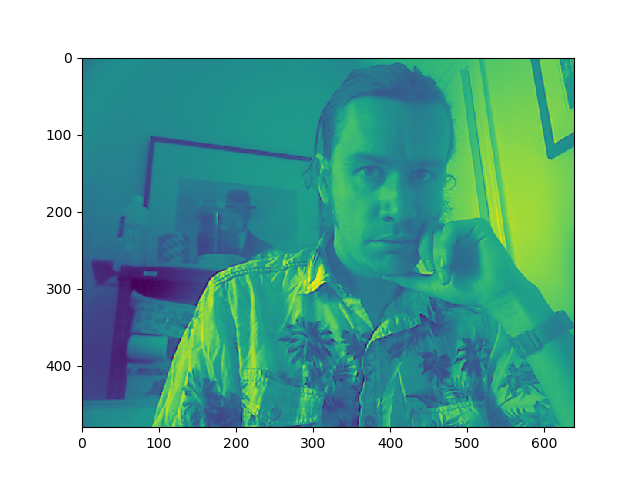

In [12]:
%matplotlib notebook
plt.imshow(frame[:, :, 0])

In [8]:
from src.sources.polar_mapping import split_field

For reference.

```
def split_field(input_image, LUT=None):
    """Convert image to polar and split across the visual field."""
    # If a look-up table is not passed, create one
    if LUT is None:
        max_size = max(input_image.shape)
        LUT = calculateLUT(max_size)
    out_image = convert_image(input_image, LUT)
    # I could possibly change the mapping above to avoid flipping
    # Flipping arranges similar to cortex
    right_image = np.flip(out_image[:180, :])
    left_image = np.flipud(out_image[180:, :])
    return norm_scale(left_image), norm_scale(right_image)
```

In [9]:
left, right = split_field(frame[:, :, 0])

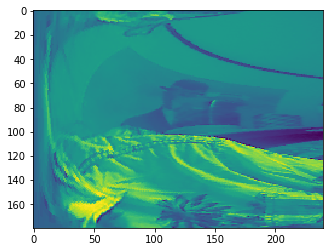

In [10]:
plt.imshow(left)

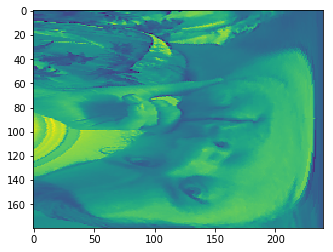

In [11]:
plt.imshow(right)

## Gaze Dynamics

Now we look at introducing some gaze dynamics. The gaze positions features of interest in the centre of the visual field, and thus provides for symmetry.

How gaze may work:
* Define a co-ordinate of gaze - a centre of vision. This is an array of length 2 - first entry is row index, second entry is column index. This can be an integer.
* If we define a default centre of the image as 0, 0, then use positive and negative values to index in x, y directions.
* Extract a region around the gaze co-ord.
* Perform retinotopic mapping.

The gaze can change. If we assume ternary values, the gaze may change by +/- 1 pixels per timestep.
* Do we start by modelling gaze as a random walk?

In the above image my face is around (200, 415).

We restrict gaze to the inner area of viewable space - so if the area is 100 (+/-50), we restrict to image size +/-50

In [24]:
# Define a 2D coordinate for the gaze centre - (y, x) - matching (row, col) array convention
gaze_centre = np.zeros(shape=(2, 1), dtype=np.int16)
# Define a fovea size
fovea_size = (50, 100)

In [25]:
y, x = gaze_centre; print(y, x)

[0] [0]


In [28]:
def get_gaze_area(image, gaze_centre, fovea_size):
    # Check gaze within inner image
    rows, cols = image.shape
    y, x = gaze_centre
    height, width = fovea_size
    assert y < (rows-height) and x < (cols-width)
    # Extract region and return
    return image[y-height:y+height, x-width:x+width]

In [29]:
region = get_gaze_area(frame[:, :, 0], np.asarray([200, 415]), fovea_size)

<IPython.core.display.Javascript object>


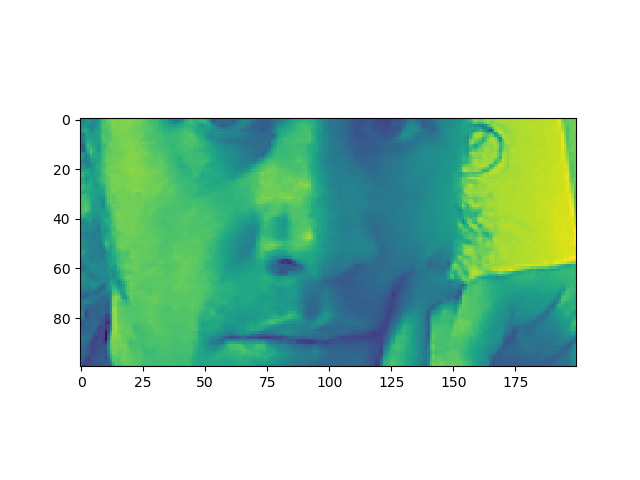

In [30]:
plt.imshow(region)

<IPython.core.display.Javascript object>


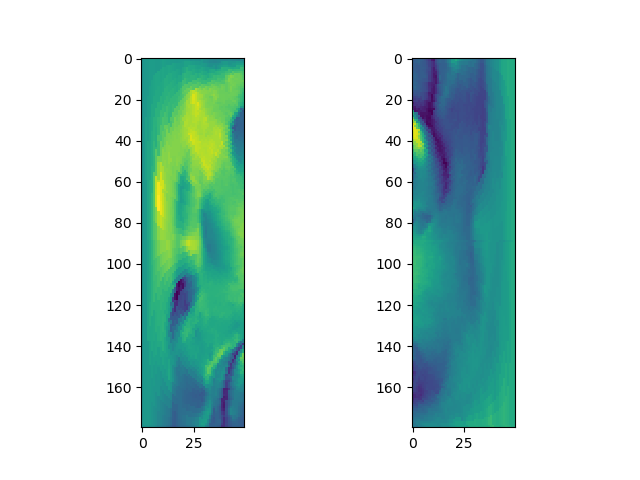

In [31]:
region_left, region_right = split_field(region)
fig, axes = plt.subplots(1, 2)
axes[0].imshow(region_left); axes[1].imshow(region_right)

In [35]:
from src.sources.polar_mapping import convert_image, calculateLUT, calculatebackLUT, show_field

In [36]:
max_size = max(region.shape); print(max_size)

200


<IPython.core.display.Javascript object>


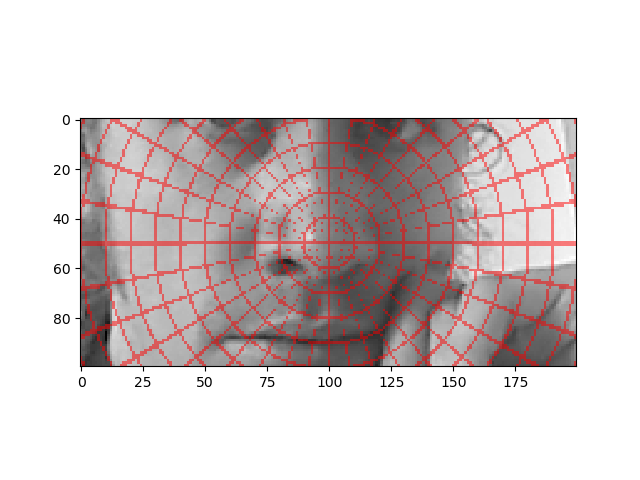

In [41]:
LUT = calculateLUT(max_size)
backLUT = calculatebackLUT(max_size)
show_field(region, backLUT, ticks=10)

Each square has a similar size representation on the retina.

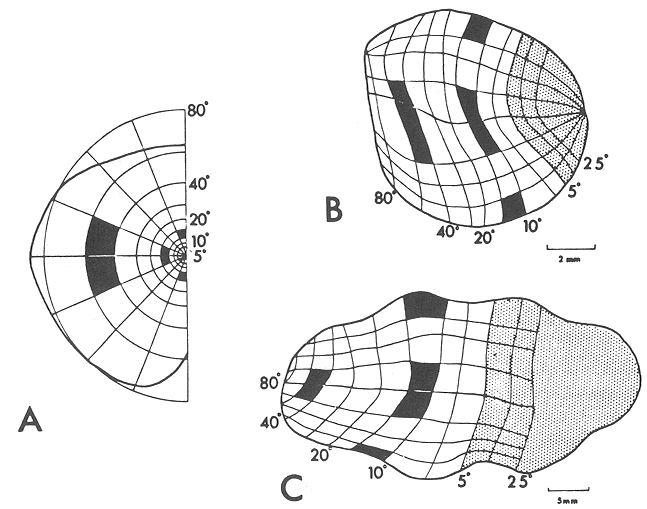

In [47]:
print(f"LUT dimensions: {LUT.shape}\nBackLUT dimensions: {backLUT.shape}")

LUT dimensions: (200, 360, 2)
BackLUT dimensions: (400, 400, 2)


So this will cover the whole image space...

<IPython.core.display.Javascript object>


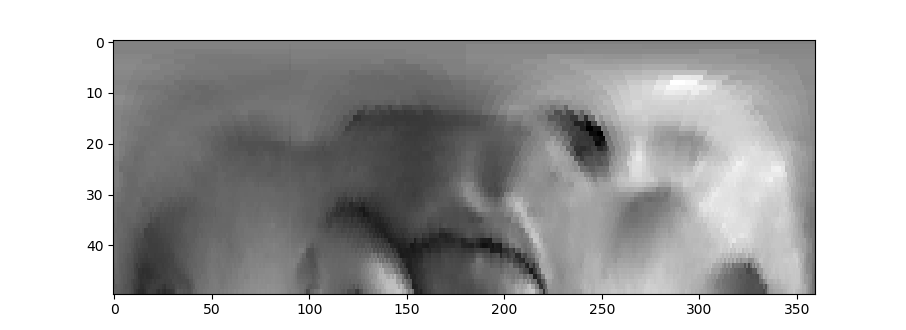

In [44]:
converted = convert_image(region, LUT)
plt.imshow(converted.T, cmap='gray', aspect="auto")

The eyes are chopped off in the above left/right images.

How is the image on the visual cortex arranged? 
* The fovea area appears square but the above is long - ah as we are splitting the field, we actually can have a 2:1 ratio.

In [49]:
img = region
# Use centre of image as origin
centre_row = img.shape[0] // 2
centre_col = img.shape[1] // 2
print(centre_row, centre_col)

50 100


In [53]:
radius = int(max(img.shape)/2); print(radius)

100


In [61]:
# Theta on Y-axis is closer to cortex maps
output_image = np.zeros(shape=(360, radius))
rows, cols = img.shape
# Iterate around angles of field of view
for angle in range(0, 360):
    # Iterate over radius
    for r in range(0, radius):
        # Get mapped x, y
        (row, col) = tuple(LUT[r, angle])
        # Translate origin to centre
        # This makes rotation clockwise from positive y axis
        m_row = centre_row - row
        m_col = col + centre_col
        if m_row < rows and m_col < cols:
            output_image[angle, r] = img[m_row, m_col]

<IPython.core.display.Javascript object>


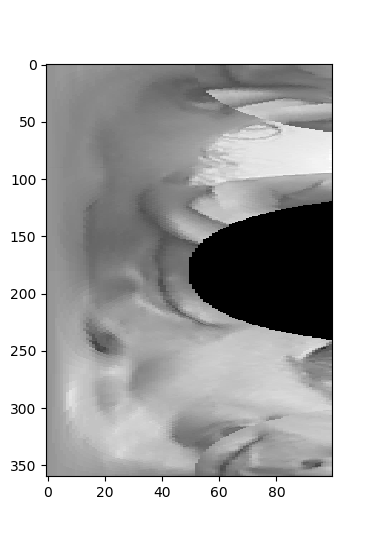

In [64]:
plt.imshow(output_image, cmap='gray', aspect="auto")

So we need to exclude those hemisphere areas if we want the extra information.

Let's just take one hemisphere to try to map better onto the image of the cortex above.

In [75]:
# Theta on Y-axis is closer to cortex maps
output_image = np.zeros(shape=(180, radius))
rows, cols = img.shape
# Iterate around angles of field of view
for angle in range(0, 180):
    # Iterate over radius
    for r in range(0, radius):
        # Get mapped x, y
        (row, col) = tuple(LUT[r, angle])
        # Translate origin to centre
        # This makes rotation clockwise from positive y axis
        m_row = centre_row - row
        m_col = col + centre_col
        if m_row < rows and m_col < cols:
            output_image[angle, r] = img[m_row, m_col]

<IPython.core.display.Javascript object>


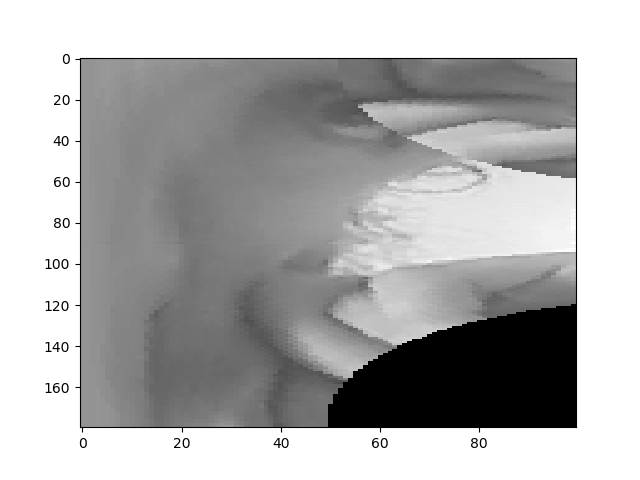

In [78]:
# Also flip to match orientation above.
plt.imshow(output_image, cmap='gray', aspect="auto")

This image isn't too different from the cortex mapping above - towards the left-hand side of the image we have some tapering. 

You could take two image halves: in the above 50-100 is of height 180, 0-50 is of height 118-58 = 60.

You want to stretch that second half to make square?

What's the formula for the upper area we need to remove. Could we mask based on the zero values of the other half?

Or we look at where r>r_min.

***Or we put the image in a bigger zero image...***

In [82]:
print(region.shape, max(region.shape), min(region.shape))

(100, 200) 200 100


In [86]:
# Calculate padding on smaller dimension
padding = (max(region.shape)-min(region.shape))//2; print(padding)

50


In [95]:
# https://stackoverflow.com/questions/10871220/making-a-matrix-square-and-padding-it-with-desired-value-in-numpy
def squarify(M, val):
    (a, b)=M.shape
    pad_factor = abs(a-b)//2
    if a < b:
        padding=((pad_factor, pad_factor), (0, 0))
    else:
        padding=((0, 0), (pad_factor, pad_factor))
    return np.pad(M, padding, mode='constant', constant_values=val)

In [97]:
padded = squarify(region, 0)

<IPython.core.display.Javascript object>


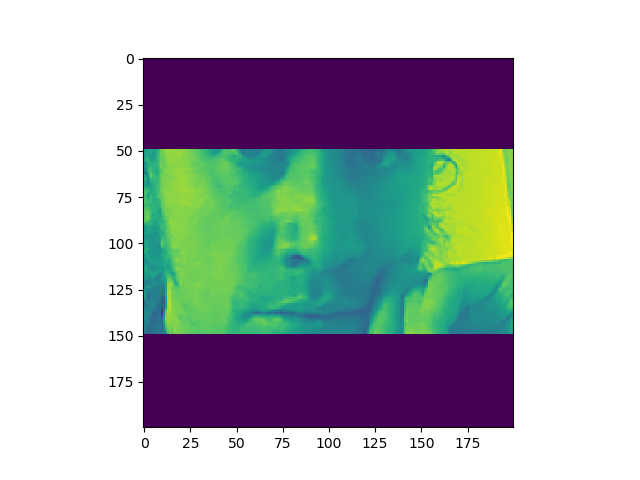

In [98]:
plt.imshow(padded)

<IPython.core.display.Javascript object>


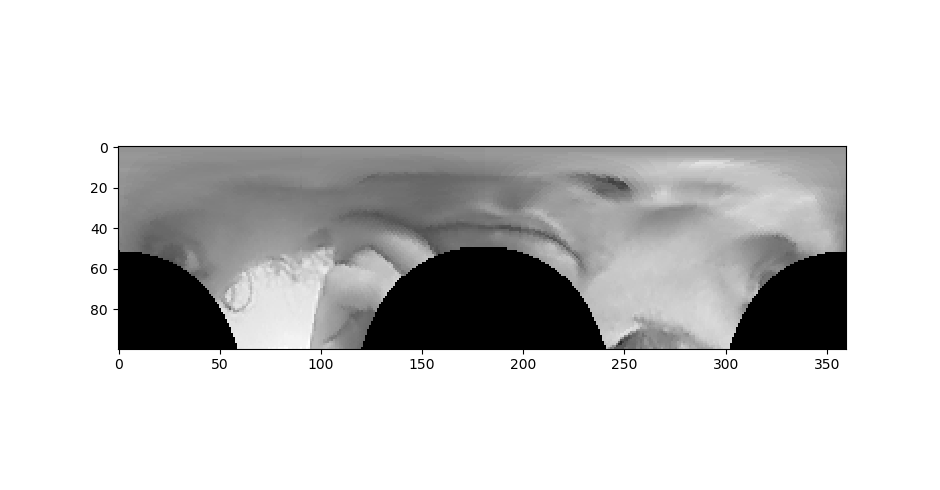

In [125]:
output = convert_image(padded, LUT)

plt.imshow(output.T, cmap="gray")

In [123]:
output.max(), output.min()

(221.0, 0.0)

<IPython.core.display.Javascript object>


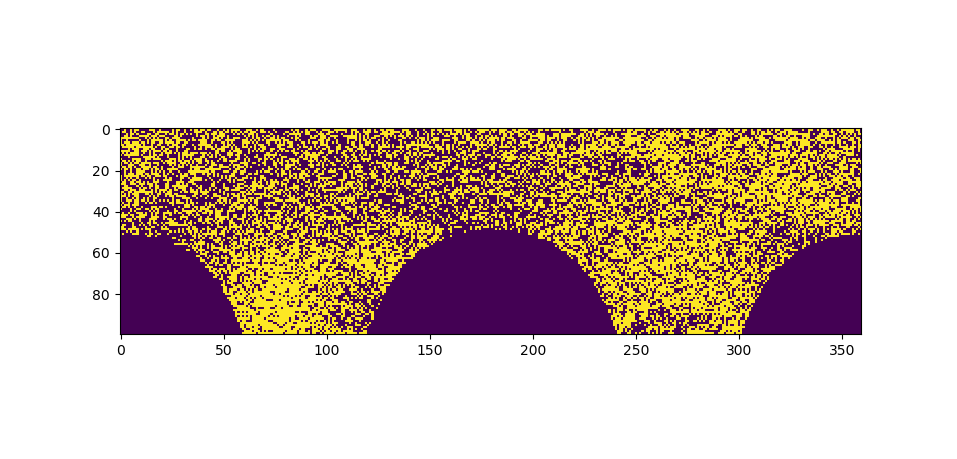

In [126]:
random_ints = np.random.randint(255, size=output.shape)
pbt = np.where(output > random_ints, 1, 0)
plt.imshow(pbt.T)

<IPython.core.display.Javascript object>


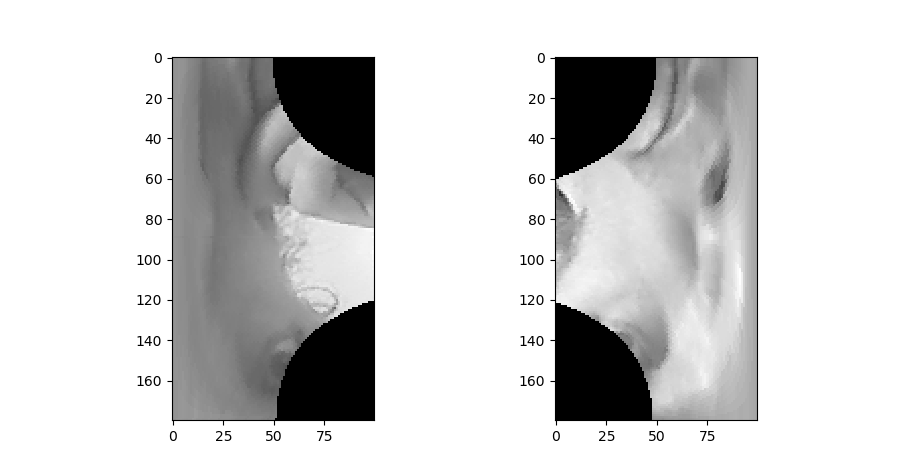

In [127]:
right_image = np.flipud(output[:180, :])
left_image = np.fliplr(output[180:, :])
fig, axes = plt.subplots(1, 2)
axes[0].imshow(right_image, cmap="gray"); axes[1].imshow(left_image, cmap="gray")

The flipping above is consistent with the projection onto each hemisphere.

But the retinotopic maps from the text books above are longer than tall...

Y axis will also be 180 as 180 degrees. X axis is set by region size. Maybe we can stride in the degree direction? 

In [132]:
def convert_image(img, LUT, angle_step=1):
    """
    Convert image from cartesian to polar co-ordinates.

    img is a numpy 2D array having shape (height, width)
    LUT is a numpy array having shape (diameter, 180, 2)
    storing [x, y] co-ords corresponding to [r, angle]
    """
    # Use centre of image as origin
    centre_row = img.shape[0] // 2
    centre_col = img.shape[1] // 2
    # Determine the largest radius
    if centre_row > centre_col:
        radius = centre_col
    else:
        radius = centre_row
    # Theta on Y-axis is closer to cortex maps
    output_image = np.zeros(shape=(360, radius))
    # Iterate around angles of field of view
    for angle in range(0, 360, angle_step):
        # Iterate over radius
        for r in range(0, radius):
            # Get mapped x, y
            (row, col) = tuple(LUT[r, angle])
            # Translate origin to centre
            # This makes rotation clockwise from positive y axis
            m_row = centre_row - row
            m_col = col+centre_col
            output_image[angle, r] = img[m_row, m_col]
    # Skip missed values
    output_image = output_image[::angle_step, :]
    return output_image

<IPython.core.display.Javascript object>


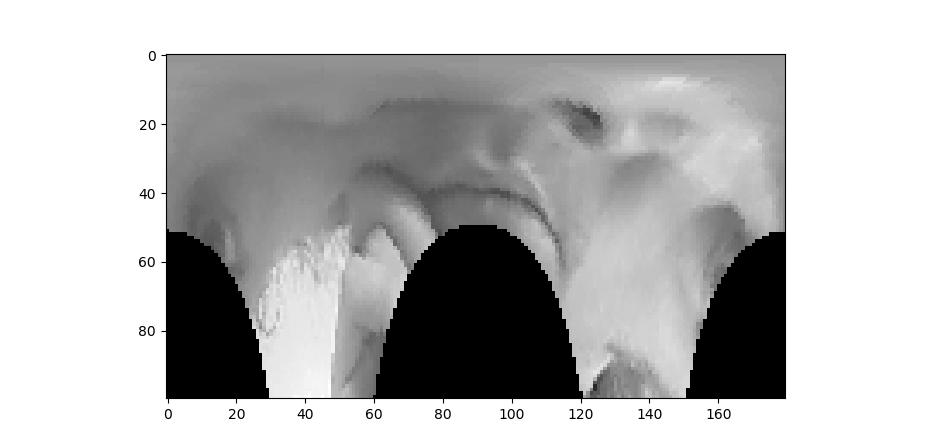

In [133]:
output = convert_image(padded, LUT, angle_step=2)

plt.imshow(output.T, cmap="gray")

<IPython.core.display.Javascript object>


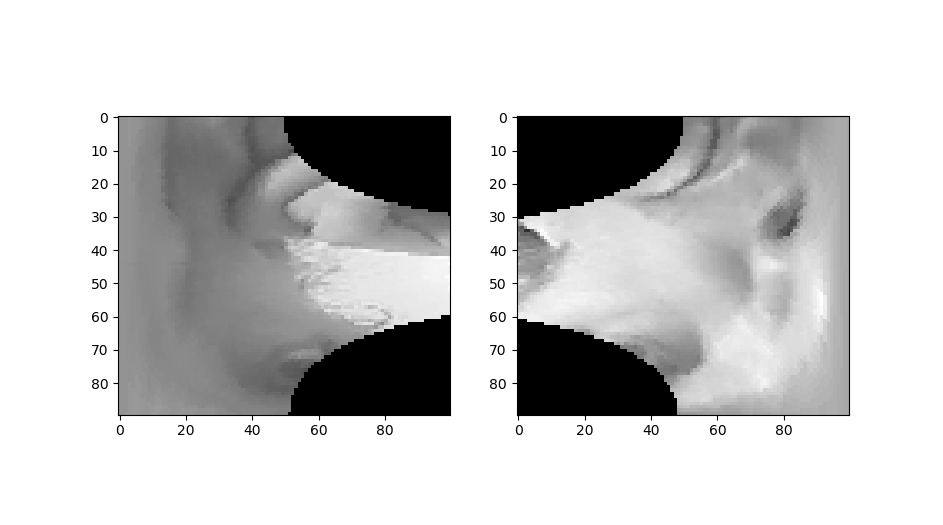

In [135]:
right_image = np.flipud(output[:90, :])
left_image = np.fliplr(output[90:, :])
fig, axes = plt.subplots(1, 2)
axes[0].imshow(right_image, cmap="gray"); axes[1].imshow(left_image, cmap="gray")

The original image was a region of 200 by 100, i.e. 20000 pixels. The images above are 100 by 90 - 9000 pixels (with some zero space).

But check the Y axis in the figures above - in the cortex map it runs from 0 degrees to 80 degrees - this is the radius - so we want a finer resolution in the radius direction to increase the resolution in the radius direction.

So to 40 degrees in the field of vision is approximately half the radius - so the resolution is double in the radius direction.

So if our original radius is 50 then we should have around a resolution of 25 in the angle direction - say a stride of 8.

<IPython.core.display.Javascript object>


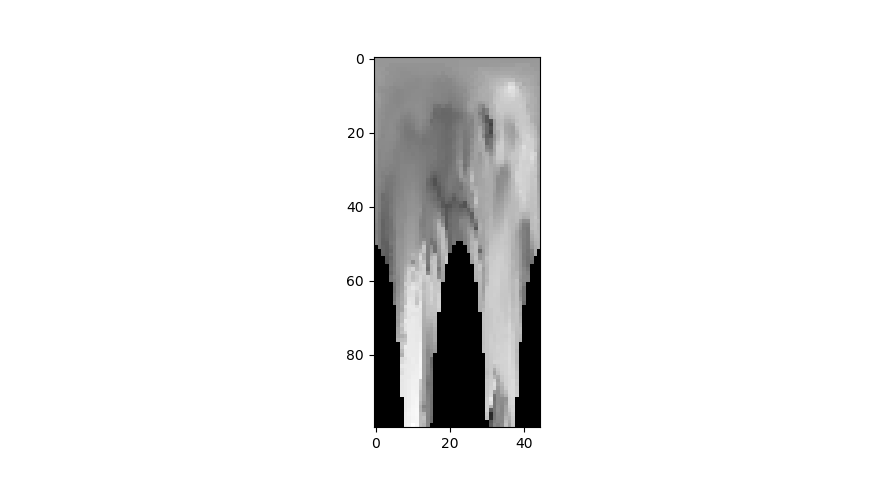

In [136]:
output = convert_image(padded, LUT, angle_step=8)

plt.imshow(output.T, cmap="gray")

In [140]:
output.shape

(45, 100)

<IPython.core.display.Javascript object>


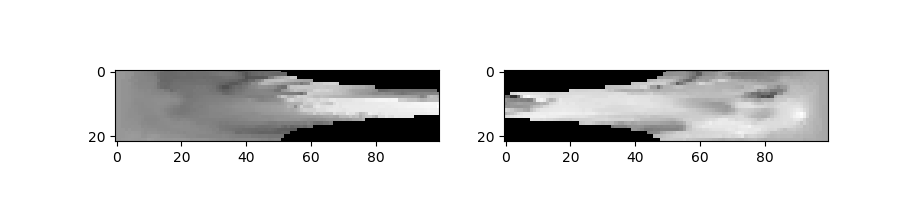

In [141]:
right_image = np.flipud(output[:output.shape[0]//2, :])
left_image = np.fliplr(output[(output.shape[0]+1)//2:, :])
fig, axes = plt.subplots(1, 2)
axes[0].imshow(right_image, cmap="gray"); axes[1].imshow(left_image, cmap="gray")

In [142]:
print(right_image.shape, left_image.shape)

(22, 100) (22, 100)


<IPython.core.display.Javascript object>


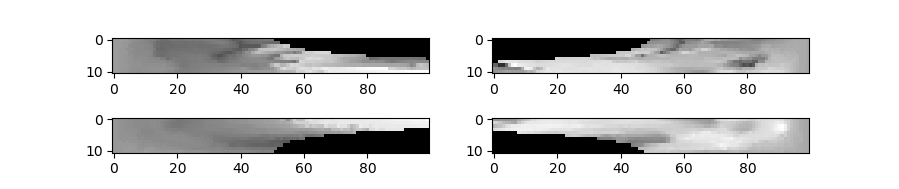

In [145]:
# Now plot top and bottom visual fields separately
fig, axes = plt.subplots(2, 2)
# Top 
axes[0, 0].imshow(right_image[:11, :], cmap="gray")
# Bottom
axes[1, 0].imshow(right_image[11:, :], cmap="gray")
# Top
axes[0, 1].imshow(left_image[:11, :], cmap="gray")
# Bottom
axes[1, 1].imshow(left_image[11:, :], cmap="gray")

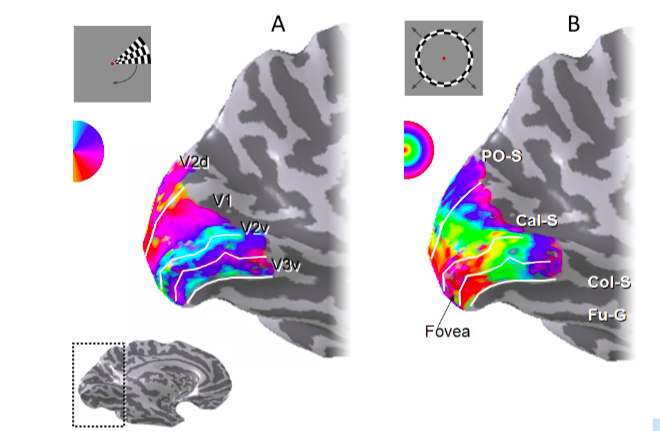

So with respect to the above, the leftmost and rightmost of each column of images is at the fovea and we have the x axis spanning out from the fovea and we have thin strips of angle with mirroring in the upper and lower fields.

## Visualiser

It would be good to have a visualiser where:
* we extract a region from the centre.
* we show the original image, the region and the four subplot above (3 x 2).

In [168]:
from matplotlib.animation import FuncAnimation

class VideoViewer:
    """Object to view video via matplotlib."""
    def __init__(self, video_source, angle_step=1):
        """Initialise."""
        self.video = video_source
        self.angle_step = angle_step
        if not self.video.started:
            self.video.start()
        # Set up plots
        self.figure, self.axes = plt.subplots(2, 3)
        self.animation = FuncAnimation(
            self.figure, self.update, interval=200, blit=True
        )
        # Initialise LUT for polar
        self.region_size = (50, 100)
        self.LUT = calculateLUT(max_size)
        # Return a list of images for display
        images = self.process_frame()
        # Initialise subplots
        self.displayed = [
            self.axes.ravel()[i].imshow(
                images[i], cmap="gray", animated=True, aspect="auto"
            )
            for i in range(len(images))
        ]
        # Clear ticks
        for ax in self.axes.ravel():
            ax.xaxis.set_major_locator(plt.NullLocator())
            # ax.yaxis.set_major_locator(plt.NullLocator())
        plt.subplots_adjust(wspace=0.5)       

    def get_frame(self):
        # Get frame
        ret, frame = self.video.read()
        # Return Y component
        return frame[:, :, 0]    
        
    def process_frame(self):
        """Process a frame."""
        # Get frame
        Y = self.get_frame()
        # Initialise list
        images = list()
        # Add large frame as first image
        images.append(Y)
        rows, cols = Y.shape
        # Set region as centre (we'll move the camera first)
        gaze_centre = (rows//2, cols//2)
        # Get central region
        region = get_gaze_area(Y, gaze_centre, self.region_size)
        # Pad and convert
        padded = squarify(region, 0)
        max_size = max(self.region_size)
        output = convert_image(padded, self.LUT, angle_step=self.angle_step)
        right_image = np.flipud(output[:output.shape[0]//2, :])
        left_image = np.fliplr(output[(output.shape[0]+1)//2:, :])
        # Add top of left image
        images.append(right_image[:right_image.shape[0]//2, :])
        # Add bottom of left image
        images.append(left_image[:left_image.shape[0]//2, :])
        # Add region as an image
        images.append(region)
        # Add top of left image
        images.append(right_image[right_image.shape[0]//2:, :])
        # Add bottom of left image
        images.append(left_image[left_image.shape[0]//2:, :])
        return images

    def update(self, i):
        """Code for frame update."""
        images = self.process_frame()
        for i, box in enumerate(self.displayed):
            box.set_data(images[i])
        return self.figure

    def show(self):
        plt.show()

    def __exit__(self, exec_type, exc_value, traceback):
        """Extra code to close camera."""
        self.video.stop()

<IPython.core.display.Javascript object>


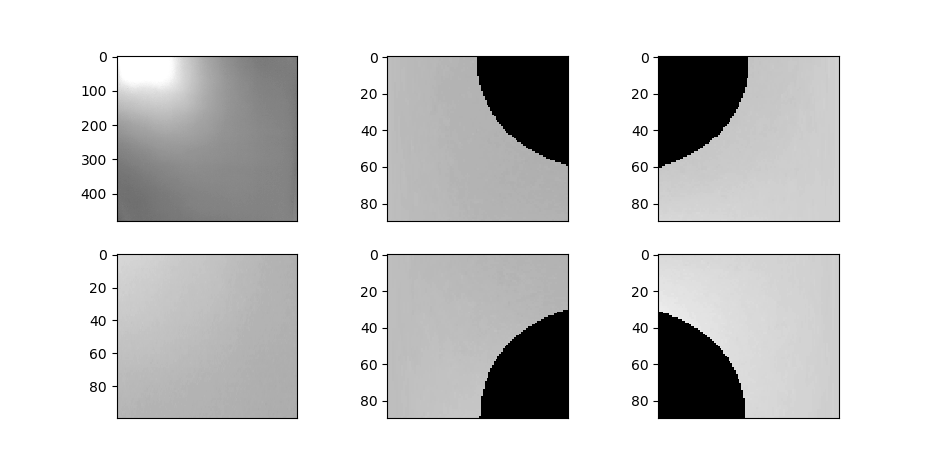

In [156]:
viewer = VideoViewer(video)

If there are about 1 million sensory signals coming into the cortex and at least 50% are taken up by the fovea, this suggests a fovean resolution of about 700 by 700.

Also when looking at text a 2MP camera isn't detailed enough to read the text.

In [162]:
cap = cv2.VideoCapture(2)
cap.set(cv2.CAP_PROP_CONVERT_RGB, 0)
# Watch out - UV are interlaced
# Set width / height if passed (locks to nearest availabe resolution)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 2000)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 2000)
# Grab a frame
grabbed, frame = cap.read()
print(frame.shape)

(800, 1280, 2)


In [163]:
cap.release()

In [172]:
video2 = VideoSource(2, 2000, 2000)
video2.start()

<IPython.core.display.Javascript object>


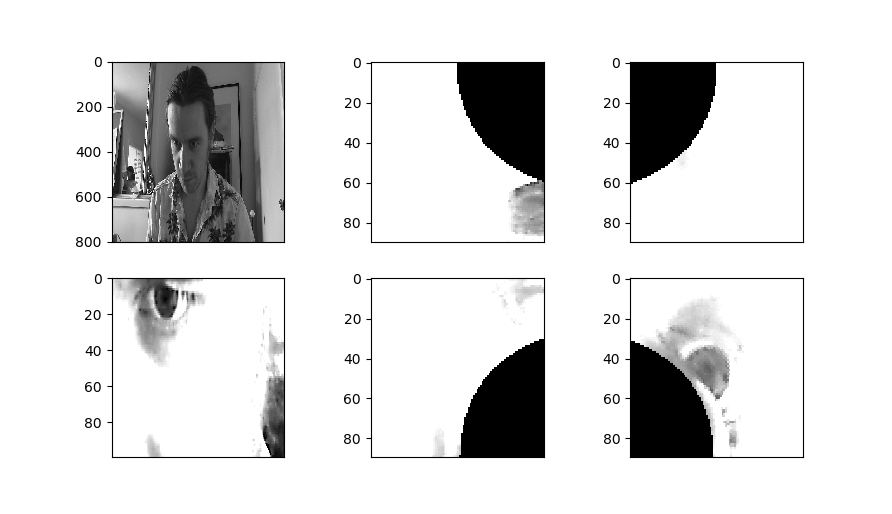

In [169]:
viewer2 = VideoViewer(video2)

In [170]:
video2.stop()

Trying to read is informative!

The brain centres by trying to match up the images in each of the four quadrants. This also seems to work for speech (looking at lips) and eyes.

The better resolution camera seems to work better. We are nearly there at 1280 * 800 - suggests actual resolution is UHDish for fovea.

You could get the same effect with two camera - a lens to focus a small area onto all of the array and a large fish eye.

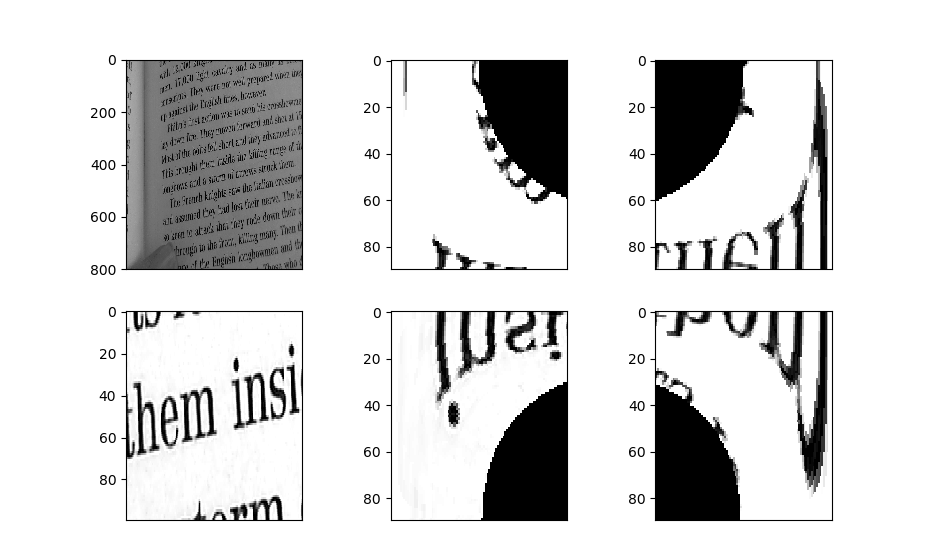

The writing is backwards in the brain - it goes from right > left. The word spacing at that distance is such that you only have single words present. You focus by making the letter height roughly equal on the upper and lower portion. The differences between the upper and lower field determine the letter. 

This also suggests that letter height can vary for the same pattern. Suggesting that vertical information is combined.

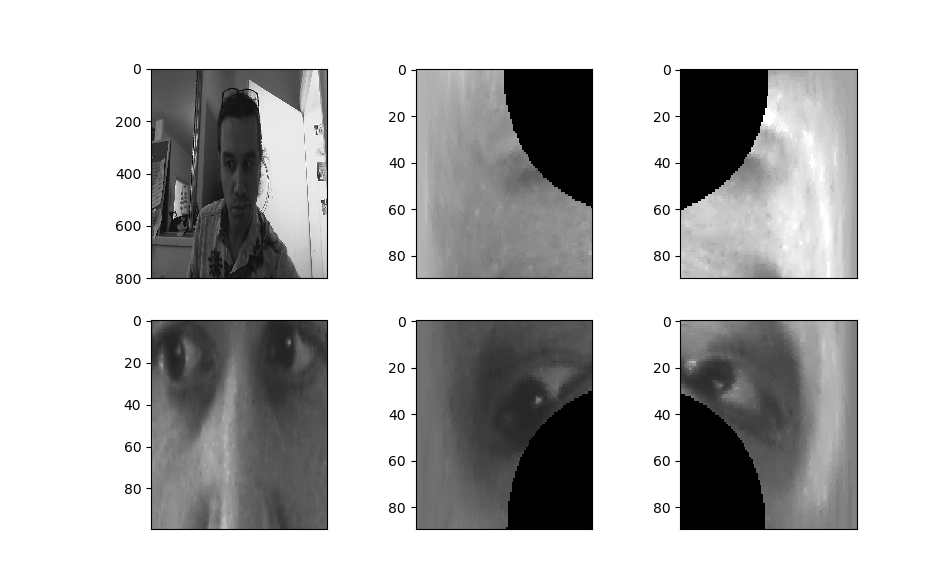

Has vision developed in lockstep with the symmetry of animals?

# PBT on Region

Let's quickly apply PBT to the region of interest. Let's start with just binary.

We can then have one where we record a rolling mean and remove it.

In [171]:
class PBTViewer(VideoViewer):
    
    def get_frame(self):
        """Get a frame of data to process."""
        Y = super(PBTViewer, self).get_frame()
        random_ints = np.random.randint(255, size=Y.shape)
        return np.where(Y > random_ints, 1, 0)

<IPython.core.display.Javascript object>


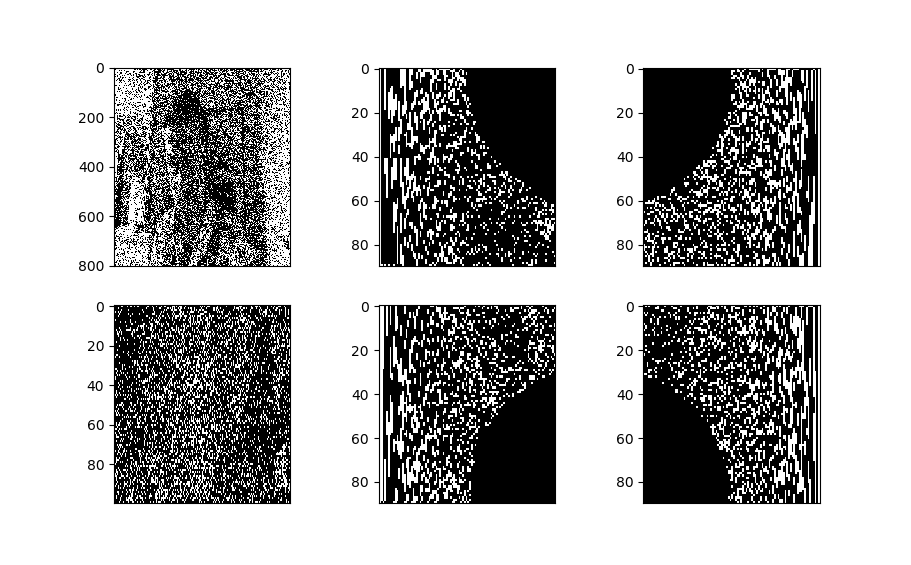

In [173]:
pbt = PBTViewer(video2)

Lip reading works when the lips are below the nose in the fovea (or across the fovea) - you have clear vertical changes - similar to text.

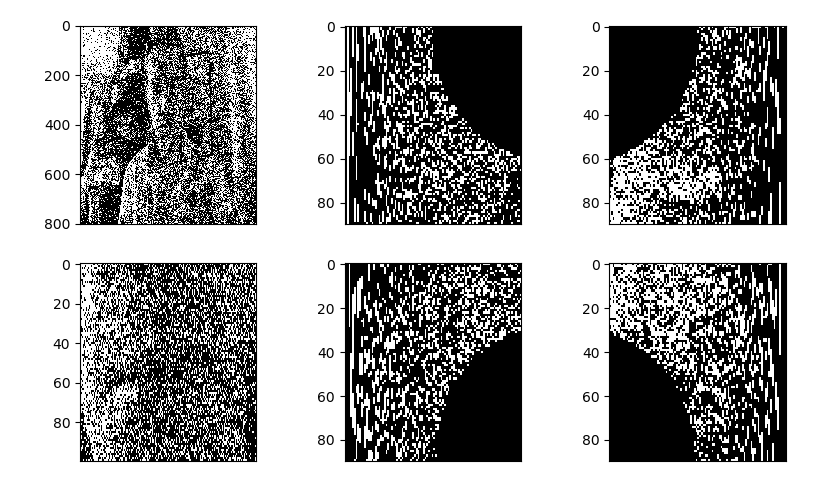
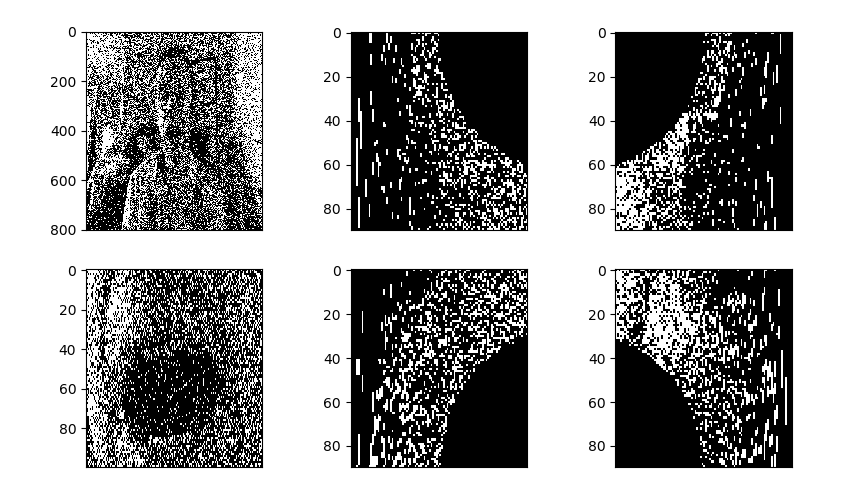

Writing seems to possibly require removal of a mean - we still have enough contrast though - especially if there is some summing over time.

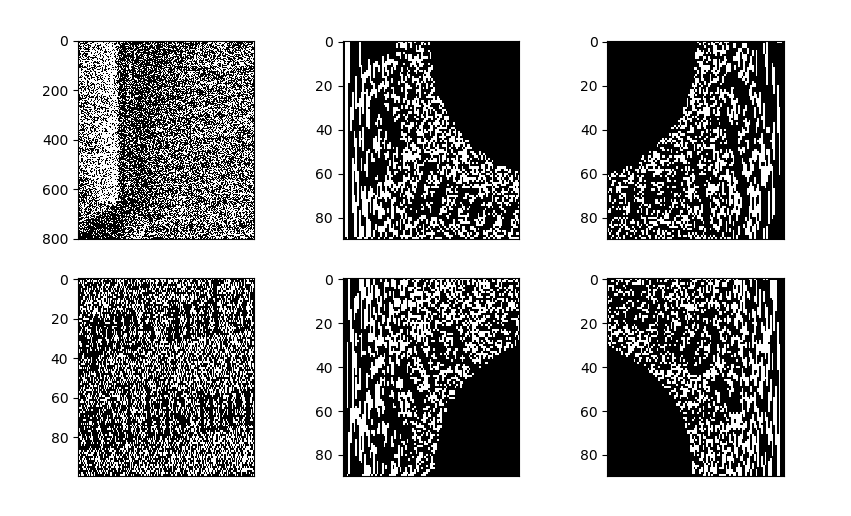

The centering seems to be autocorrelation in the vertical direction, and horizontal between hemispheres.

## Mean Removal PBT

If we have 32 bit integers we can sum over 16 million frames. If we have 16-bit integers we can sum over 256 frames.

In [316]:
from src.var_processor.pb_threshold import signal_pre_processor

# Try PBT with mean removal
class TernaryPBTViewer(PBTViewer):
    
    def __init__(self, video_source, angle_step=1, mean_batch=255):
        # Define additional variables for a rolling mean
        self.rolling_sum = None
        self.count = 0
        self.mean = None
        # Set the batch size for the mean
        self.mean_batch = mean_batch
        # Call original init
        super(TernaryPBTViewer, self).__init__(video_source, angle_step)
        
    def get_frame(self):
        """Get a frame of data to process."""
        Y = super(PBTViewer, self).get_frame()
        # If first run initialise sum
        if self.rolling_sum is None:
            self.rolling_sum = np.zeros(shape=(Y.shape), dtype=np.uint32)
        # Add to rolling sum and increment count
        self.rolling_sum += Y
        self.count += 1
        # Calculate the mean
        temp_mean = self.rolling_sum // self.count
        # Add factor from previous mean
        if self.mean is None:
            mean = temp_mean
        else:
            mean = (self.mean + temp_mean) // 2 
        # When batch limit is reached store mean
        if self.count > self.mean_batch:
            self.count = 0
            self.mean = mean
            # Reset rolling sum
            self.rolling_sum.fill(0)
        # Convert to signed integers before processing otherwise under/over flow
        Y = Y.astype(np.int16)
        mean = mean.astype(np.int16)
        pbt = signal_pre_processor(Y, mean, signal_max=254)
        return pbt
    
    def update(self, i):
        """Code for frame update."""
        images = self.process_frame()
        for i, box in enumerate(self.displayed):
            box.set_clim(-1, 1)
            box.set_data(images[i])
        return self.figure
        

<IPython.core.display.Javascript object>


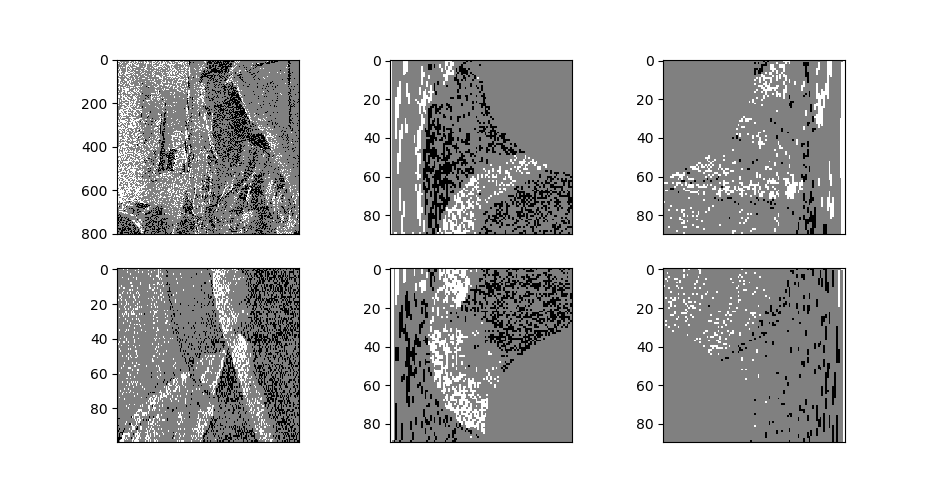

In [317]:
tpbt = TernaryPBTViewer(video2, mean_batch=32)

An interesting point about the mean removal is that it needs to be adaptive - if we look at a face then the book then the face we actually just want to remove a short term local mean.

Thinking of closing the eyes and looking at shapes on the eyelids - the mean is only a short term mean.

<IPython.core.display.Javascript object>


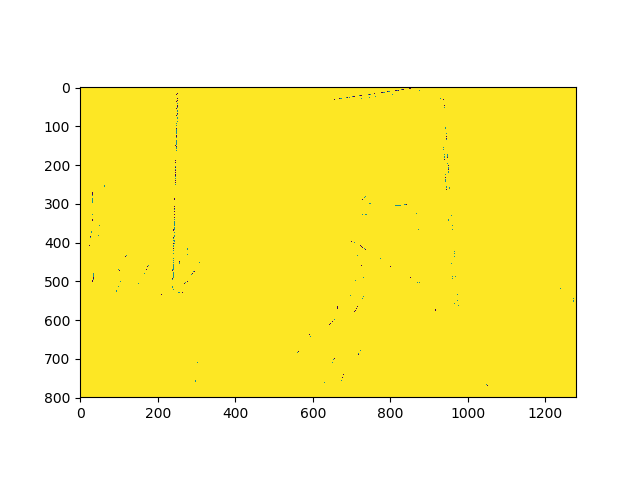

In [240]:
frame = tpbt.get_frame()

plt.imshow(frame)

In [295]:
tpbt.rolling_sum//tpbt.count

array([[16, 16, 16, ..., 17,  0,  1],
       [16, 16, 16, ..., 17, 19,  0],
       [16, 16, 16, ..., 17, 19,  0],
       ...,
       [ 1,  1,  1, ...,  9,  8,  7],
       [ 0,  0,  0, ...,  7,  6,  6],
       [ 0, 19, 18, ...,  5,  4,  4]], dtype=uint8)

In [302]:
tpbt.rolling_sum

array([[157, 170, 170, ..., 122,  10,  76],
       [177, 192, 192, ..., 120,   6,  66],
       [177, 192, 192, ..., 132,   3,  63],
       ...,
       [108, 126, 127, ...,  28, 224, 169],
       [124, 124, 114, ..., 173, 129,  87],
       [110,  99,  76, ...,  89,  41, 253]], dtype=uint8)

In [311]:
tpbt.count

8

In [312]:
tpbt.mean

array([[181, 181, 181, ..., 167, 167, 168],
       [182, 181, 181, ..., 167, 168, 168],
       [182, 182, 182, ..., 167, 168, 168],
       ...,
       [ 62,  62,  62, ..., 106, 105, 105],
       [ 62,  62,  62, ..., 106, 105, 104],
       [ 61,  61,  61, ..., 106, 105, 104]], dtype=uint32)

The eyes tend to adapt using a form of moving average - https://stackoverflow.com/questions/14313510/how-to-calculate-moving-average-using-numpy and https://en.wikipedia.org/wiki/Moving_average.

This just requires a buffer of n values, where n is the batch_length. We just take the mean of the buffer? Or if it is quicker we can store the -n th value and as we move forward add the (new value - nth value)/n

In [319]:
(2, 1) + (3, )

(2, 1, 3)

In [321]:
24 % 25

24

In [364]:
# Try PBT with rolling mean removal 
class TernaryPBTViewer2(PBTViewer):
    
    def __init__(self, video_source, angle_step=1, ma_length=32):
        # Define additional variables for a rolling mean
        self.rolling_mean = None
        self.count = 0
        self.buffer = None
        # Set the batch size for the mean
        self.ma_length = ma_length
        # Call original init
        super(TernaryPBTViewer2, self).__init__(video_source, angle_step)
        
    def get_frame(self):
        """Get a frame of data to process."""
        Y = super(PBTViewer, self).get_frame()
        if self.buffer is None:
            # Initialise buffer
            self.buffer = np.zeros(shape=Y.shape + (self.ma_length, ))
        # If first run initialise sum
        if self.rolling_mean is None:
            self.rolling_mean = np.zeros(shape=(Y.shape)) # Watch out this needs to be a float
            # Or it can be an uint32 but we'd need to divide by the ma_length later
        # Get previous value at count (or zero if empty)
        old_Y = self.buffer[:, :, self.count % self.ma_length].copy()
        # Add current frame to buffer
        self.buffer[:, :, self.count % self.ma_length] = Y
        # Add new frame - old frame to rolling mean
        print(Y, old_Y)
        self.rolling_mean = self.rolling_mean + (Y - old_Y)/self.ma_length
        # Increment count
        self.count += 1
        # Format as signed ints for subtraction
        Y = Y.astype(np.int16)
        mean = self.rolling_mean.astype(np.int16)
        pbt = signal_pre_processor(Y, mean, signal_max=254)
        return pbt
    
    def update(self, i):
        """Code for frame update."""
        images = self.process_frame()
        for i, box in enumerate(self.displayed):
            box.set_clim(-1, 1)
            box.set_data(images[i])
        return self.figure

<IPython.core.display.Javascript object>


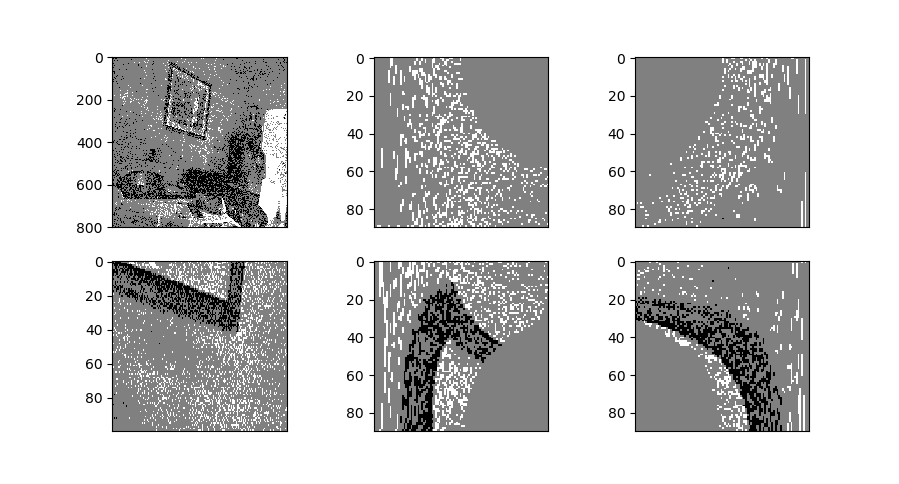

[[233 233 233 ... 176 171 174]
 [233 233 233 ... 176 175 176]
 [233 233 233 ... 177 177 177]
 ...
 [ 59  60  61 ... 176 172 170]
 [ 58  58  60 ... 175 174 173]
 [ 58  58  59 ... 174 174 174]] [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [365]:
tpbt2 = TernaryPBTViewer2(video2, ma_length=32)

Do we need to compute the complete rolling sum first before subtracting?

No - on the first run, it should sum over 32 iterations 32 readings that are divided by 32. Then when the buffer is full it only adds a small factor.

***Ah it's because the end small factor will not be a nice integer division.***

<IPython.core.display.Javascript object>


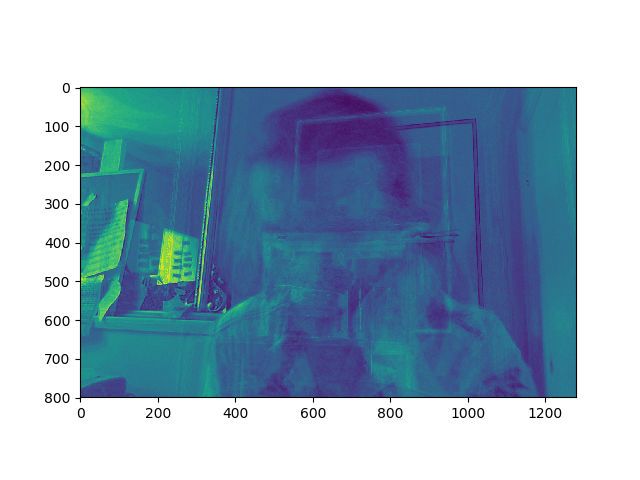

In [361]:
plt.imshow(tpbt2.rolling_mean)

In [354]:
tpbt2.count

198

In [355]:
tpbt2.count % tpbt2.ma_length

7

In [358]:
tpbt2.buffer

array([[[232., 232., 232., ..., 232., 231., 232.],
        [232., 232., 232., ..., 232., 231., 232.],
        [232., 232., 232., ..., 232., 231., 232.],
        ...,
        [166., 167., 166., ..., 167., 166., 166.],
        [166., 167., 167., ..., 166., 166., 166.],
        [166., 166., 168., ..., 162., 166., 165.]],

       [[232., 232., 232., ..., 232., 231., 232.],
        [232., 232., 232., ..., 232., 231., 232.],
        [232., 232., 232., ..., 232., 231., 232.],
        ...,
        [166., 169., 167., ..., 168., 167., 167.],
        [166., 167., 167., ..., 167., 167., 167.],
        [166., 166., 168., ..., 167., 167., 166.]],

       [[232., 232., 232., ..., 232., 232., 232.],
        [232., 232., 232., ..., 232., 232., 232.],
        [232., 232., 232., ..., 232., 232., 232.],
        ...,
        [168., 171., 167., ..., 169., 168., 168.],
        [167., 167., 167., ..., 170., 168., 167.],
        [166., 166., 168., ..., 169., 168., 167.]],

       ...,

       [[ 55.,  55.,  61

In [359]:
(tpbt2.buffer[..., 20] - 0)//tpbt2.ma_length

array([[7., 7., 7., ..., 5., 5., 5.],
       [7., 7., 7., ..., 5., 5., 5.],
       [7., 7., 7., ..., 5., 5., 5.],
       ...,
       [1., 1., 1., ..., 4., 4., 4.],
       [1., 1., 1., ..., 4., 4., 4.],
       [1., 1., 1., ..., 4., 4., 4.]])

In [368]:
video2.stop()

In [367]:
video2.start()

## Visual Acuity Drop Off

1/(1+0.5x)
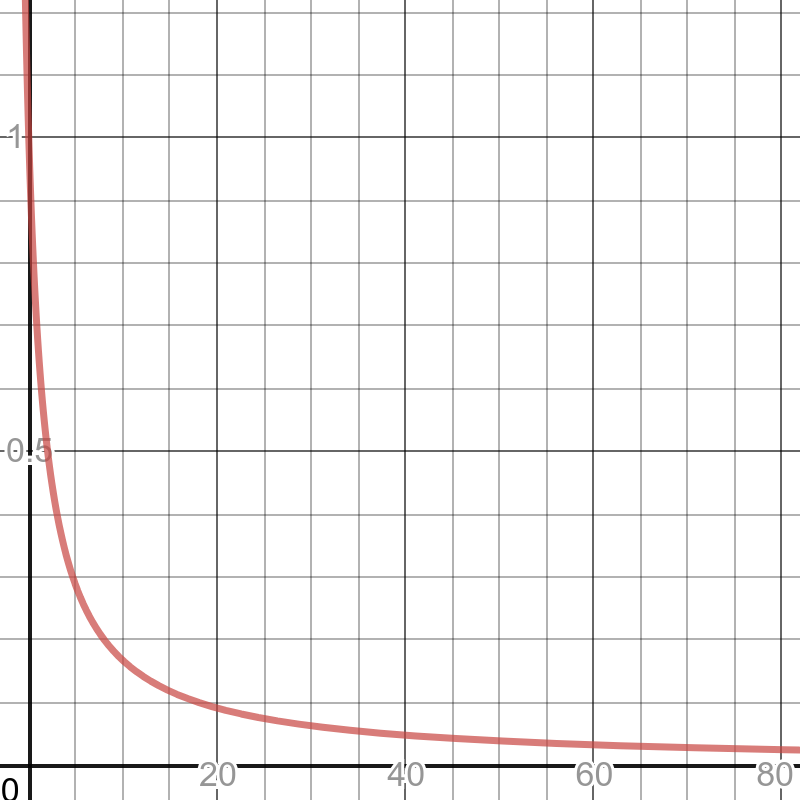

In [371]:
x_range = np.arange(0, 200)
pixel_number = 128 / (1+0.5*x_range)
print(pixel_number.astype(np.uint8))

[128  85  64  51  42  36  32  28  25  23  21  19  18  17  16  15  14  13
  12  12  11  11  10  10   9   9   9   8   8   8   8   7   7   7   7   6
   6   6   6   6   6   5   5   5   5   5   5   5   5   5   4   4   4   4
   4   4   4   4   4   4   4   4   4   3   3   3   3   3   3   3   3   3
   3   3   3   3   3   3   3   3   3   3   3   3   2   2   2   2   2   2
   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2
   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2   2
   2   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1   1
   1   1]


In the plots above the vertical direction is the angle and the horizontal direction is r or the field of view angle (x above).

There is a fixed angular (rotation) resolution but a decreasing resolution with r. How does this work in 2D?

In the plots above our number of rows is fixed but our number of columns varies. We kind of have this already with the zeroes. To plot we'd need to add back in the zeros as above.

Or to view we can interpolate / upsample an original. We could have a list rather than a numpy array with the resolutions as above - and then have a render function that converts to an image square...

How do we adapt the convert_image function to work?

```
# Theta on Y-axis is closer to cortex maps
output_image = np.zeros(shape=(360, radius))
rows, cols = img.shape
# Iterate around angles of field of view
for angle in range(0, 360):
    # Iterate over radius
    for r in range(0, radius):
        # Get mapped x, y
        (row, col) = tuple(LUT[r, angle])
        # Translate origin to centre
        # This makes rotation clockwise from positive y axis
        m_row = centre_row - row
        m_col = col + centre_col
        if m_row < rows and m_col < cols:
            output_image[angle, r] = img[m_row, m_col]
```

Gaussian filtering is the typical way to do this, but actually the acuity is due to the distribution of receptors - so just skipping might work.

So we are looking at the inner loop for radius - when radius = 0 we have 128 pixels, when radius = 1, we have 85 pixels.

Is the resolution in the angle direction?

We can assume even spacing. So for 0 radius we have 128 points, for 1 radius we have 85 pixels.

***But do the pixel radius values translate to the field of view angles?*** Yes - because 0 to 1 has 128 pixels.

The angle positions we can compute by dividing 360 / (number of points * 2)

In [377]:
360/((pixel_number*2).astype(np.uint16))

array([  1.40625   ,   2.11764706,   2.8125    ,   3.52941176,
         4.23529412,   4.93150685,   5.625     ,   6.42857143,
         7.05882353,   7.82608696,   8.57142857,   9.23076923,
        10.        ,  10.58823529,  11.25      ,  12.        ,
        12.85714286,  13.84615385,  14.4       ,  15.        ,
        15.65217391,  16.36363636,  17.14285714,  18.        ,
        18.94736842,  20.        ,  20.        ,  21.17647059,
        21.17647059,  22.5       ,  22.5       ,  24.        ,
        24.        ,  25.71428571,  25.71428571,  27.69230769,
        27.69230769,  27.69230769,  30.        ,  30.        ,
        30.        ,  32.72727273,  32.72727273,  32.72727273,
        32.72727273,  36.        ,  36.        ,  36.        ,
        36.        ,  36.        ,  40.        ,  40.        ,
        40.        ,  40.        ,  40.        ,  45.        ,
        45.        ,  45.        ,  45.        ,  45.        ,
        45.        ,  45.        ,  45.        ,  51.42

In [376]:
((pixel_number*2).astype(np.uint16))

array([256, 170, 128, 102,  85,  73,  64,  56,  51,  46,  42,  39,  36,
        34,  32,  30,  28,  26,  25,  24,  23,  22,  21,  20,  19,  18,
        18,  17,  17,  16,  16,  15,  15,  14,  14,  13,  13,  13,  12,
        12,  12,  11,  11,  11,  11,  10,  10,  10,  10,  10,   9,   9,
         9,   9,   9,   8,   8,   8,   8,   8,   8,   8,   8,   7,   7,
         7,   7,   7,   7,   7,   7,   7,   6,   6,   6,   6,   6,   6,
         6,   6,   6,   6,   6,   6,   5,   5,   5,   5,   5,   5,   5,
         5,   5,   5,   5,   5,   5,   5,   5,   5,   5,   4,   4,   4,
         4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   4,
         4,   4,   4,   4,   4,   4,   4,   4,   4,   4,   3,   3,   3,
         3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
         3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
         3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
         2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   2,   

If we have 5 pixels per degree, what is our function in pixels?

We are just increasing our x axis resolution by 5. Our function is 1/(1+0.5x/5) = 1/(1+0.1x)

In [384]:
x_range = np.arange(0, 400)
pixel_number = 127 / (1+0.1*x_range)
print(pixel_number.astype(np.uint8))

[127 115 105  97  90  84  79  74  70  66  63  60  57  55  52  50  48  47
  45  43  42  40  39  38  37  36  35  34  33  32  31  30  30  29  28  28
  27  27  26  25  25  24  24  23  23  23  22  22  21  21  21  20  20  20
  19  19  19  18  18  18  18  17  17  17  17  16  16  16  16  16  15  15
  15  15  15  14  14  14  14  14  14  13  13  13  13  13  13  13  12  12
  12  12  12  12  12  12  11  11  11  11  11  11  11  11  11  11  10  10
  10  10  10  10  10  10  10  10  10  10   9   9   9   9   9   9   9   9
   9   9   9   9   9   9   8   8   8   8   8   8   8   8   8   8   8   8
   8   8   8   8   8   7   7   7   7   7   7   7   7   7   7   7   7   7
   7   7   7   7   7   7   7   7   7   7   6   6   6   6   6   6   6   6
   6   6   6   6   6   6   6   6   6   6   6   6   6   6   6   6   6   6
   6   6   6   6   5   5   5   5   5   5   5   5   5   5   5   5   5   5
   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5   5
   5   5   5   5   5   5   5   5   5   5   5   4   

Ah but we still have 128 pixels between 0 and 1 degrees - so we need to change our intercept.

Integral 10ln(|1+0.1\*5|)-10ln(1) = 4.05
This needs to equal 128 so we need 128/4 say = 32.

In [4]:
x_range = np.arange(0, 400)
pixel_number = 32 / (1+0.1*x_range)
print(pixel_number.astype(np.uint8))

[32 29 26 24 22 21 20 18 17 16 16 15 14 13 13 12 12 11 11 11 10 10 10  9
  9  9  8  8  8  8  8  7  7  7  7  7  6  6  6  6  6  6  6  6  5  5  5  5
  5  5  5  5  5  5  5  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4  3
  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3  3
  3  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2
  2  2  2  2  2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0

Now working out angle resolution we have 360 / (2\*pixel_number) - 2 for both sides. This means we have 360 / (32\*2) * (1+0.1x).

Might it be easier to go to 30?

In [387]:
# Angles - with 32
(360 / 64)*(1+0.1*x_range)

array([  5.625 ,   6.1875,   6.75  ,   7.3125,   7.875 ,   8.4375,
         9.    ,   9.5625,  10.125 ,  10.6875,  11.25  ,  11.8125,
        12.375 ,  12.9375,  13.5   ,  14.0625,  14.625 ,  15.1875,
        15.75  ,  16.3125,  16.875 ,  17.4375,  18.    ,  18.5625,
        19.125 ,  19.6875,  20.25  ,  20.8125,  21.375 ,  21.9375,
        22.5   ,  23.0625,  23.625 ,  24.1875,  24.75  ,  25.3125,
        25.875 ,  26.4375,  27.    ,  27.5625,  28.125 ,  28.6875,
        29.25  ,  29.8125,  30.375 ,  30.9375,  31.5   ,  32.0625,
        32.625 ,  33.1875,  33.75  ,  34.3125,  34.875 ,  35.4375,
        36.    ,  36.5625,  37.125 ,  37.6875,  38.25  ,  38.8125,
        39.375 ,  39.9375,  40.5   ,  41.0625,  41.625 ,  42.1875,
        42.75  ,  43.3125,  43.875 ,  44.4375,  45.    ,  45.5625,
        46.125 ,  46.6875,  47.25  ,  47.8125,  48.375 ,  48.9375,
        49.5   ,  50.0625,  50.625 ,  51.1875,  51.75  ,  52.3125,
        52.875 ,  53.4375,  54.    ,  54.5625,  55.125 ,  55.6

In [388]:
# angles with 30
(360 / 60)*(1+0.1*x_range)

array([  6. ,   6.6,   7.2,   7.8,   8.4,   9. ,   9.6,  10.2,  10.8,
        11.4,  12. ,  12.6,  13.2,  13.8,  14.4,  15. ,  15.6,  16.2,
        16.8,  17.4,  18. ,  18.6,  19.2,  19.8,  20.4,  21. ,  21.6,
        22.2,  22.8,  23.4,  24. ,  24.6,  25.2,  25.8,  26.4,  27. ,
        27.6,  28.2,  28.8,  29.4,  30. ,  30.6,  31.2,  31.8,  32.4,
        33. ,  33.6,  34.2,  34.8,  35.4,  36. ,  36.6,  37.2,  37.8,
        38.4,  39. ,  39.6,  40.2,  40.8,  41.4,  42. ,  42.6,  43.2,
        43.8,  44.4,  45. ,  45.6,  46.2,  46.8,  47.4,  48. ,  48.6,
        49.2,  49.8,  50.4,  51. ,  51.6,  52.2,  52.8,  53.4,  54. ,
        54.6,  55.2,  55.8,  56.4,  57. ,  57.6,  58.2,  58.8,  59.4,
        60. ,  60.6,  61.2,  61.8,  62.4,  63. ,  63.6,  64.2,  64.8,
        65.4,  66. ,  66.6,  67.2,  67.8,  68.4,  69. ,  69.6,  70.2,
        70.8,  71.4,  72. ,  72.6,  73.2,  73.8,  74.4,  75. ,  75.6,
        76.2,  76.8,  77.4,  78. ,  78.6,  79.2,  79.8,  80.4,  81. ,
        81.6,  82.2,

Ah - this is saying for the finest resolution you have spacing of 6 degrees - past 180 you have less than 1 per whole ring.

So for r = 0, you iterate through every 6 degrees, for r = 1 every 6.6 etc.

In [389]:
# angles with 30
((360 / 60)*(1+0.1*x_range)).astype(np.uint8)

array([  6,   6,   7,   7,   8,   9,   9,  10,  10,  11,  12,  12,  13,
        13,  14,  15,  15,  16,  16,  17,  18,  18,  19,  19,  20,  21,
        21,  22,  22,  23,  24,  24,  25,  25,  26,  27,  27,  28,  28,
        29,  30,  30,  31,  31,  32,  33,  33,  34,  34,  35,  36,  36,
        37,  37,  38,  39,  39,  40,  40,  41,  42,  42,  43,  43,  44,
        45,  45,  46,  46,  47,  48,  48,  49,  49,  50,  51,  51,  52,
        52,  53,  54,  54,  55,  55,  56,  57,  57,  58,  58,  59,  60,
        60,  61,  61,  62,  63,  63,  64,  64,  65,  66,  66,  67,  67,
        68,  69,  69,  70,  70,  71,  72,  72,  73,  73,  74,  75,  75,
        76,  76,  77,  78,  78,  79,  79,  80,  81,  81,  82,  82,  83,
        84,  84,  85,  85,  86,  87,  87,  88,  88,  89,  90,  90,  91,
        91,  92,  93,  93,  94,  94,  95,  96,  96,  97,  97,  98,  99,
        99, 100, 100, 101, 102, 102, 103, 103, 104, 105, 105, 106, 106,
       107, 108, 108, 109, 109, 110, 111, 111, 112, 112, 113, 11

These are the step sizes for each r iteration. 

So we actually want to flip the loops around and iterate through r first. We then select ```angle_step = step_size[r]```. We then perform the inner loop based on the angle_step if angle step <= 180. We then have a list of numpy arrays.

Do we also want to offset?
* For one 

We can have a function that converts the list into a square image by 

In [6]:
# If we have 5112 or 1024 pixels
((512 / 64) * (1+0.1*x_range)).astype(np.uint16)

array([  8,   8,   9,  10,  11,  12,  12,  13,  14,  15,  16,  16,  17,
        18,  19,  20,  20,  21,  22,  23,  24,  24,  25,  26,  27,  28,
        28,  29,  30,  31,  32,  32,  33,  34,  35,  36,  36,  37,  38,
        39,  40,  40,  41,  42,  43,  44,  44,  45,  46,  47,  48,  48,
        49,  50,  51,  52,  52,  53,  54,  55,  56,  56,  57,  58,  59,
        60,  60,  61,  62,  63,  64,  64,  65,  66,  67,  68,  68,  69,
        70,  71,  72,  72,  73,  74,  75,  76,  76,  77,  78,  79,  80,
        80,  81,  82,  83,  84,  84,  85,  86,  87,  88,  88,  89,  90,
        91,  92,  92,  93,  94,  95,  96,  96,  97,  98,  99, 100, 100,
       101, 102, 103, 104, 104, 105, 106, 107, 108, 108, 109, 110, 111,
       112, 112, 113, 114, 115, 116, 116, 117, 118, 119, 120, 120, 121,
       122, 123, 124, 124, 125, 126, 127, 128, 128, 129, 130, 131, 132,
       132, 133, 134, 135, 136, 136, 137, 138, 139, 140, 140, 141, 142,
       143, 144, 144, 145, 146, 147, 148, 148, 149, 150, 151, 15

In [7]:
((1024 / 64) * (1+0.1*x_range)).astype(np.uint16)

array([ 16,  17,  19,  20,  22,  24,  25,  27,  28,  30,  32,  33,  35,
        36,  38,  40,  41,  43,  44,  46,  48,  49,  51,  52,  54,  56,
        57,  59,  60,  62,  64,  65,  67,  68,  70,  72,  73,  75,  76,
        78,  80,  81,  83,  84,  86,  88,  89,  91,  92,  94,  96,  97,
        99, 100, 102, 104, 105, 107, 108, 110, 112, 113, 115, 116, 118,
       120, 121, 123, 124, 126, 128, 129, 131, 132, 134, 136, 137, 139,
       140, 142, 144, 145, 147, 148, 150, 152, 153, 155, 156, 158, 160,
       161, 163, 164, 166, 168, 169, 171, 172, 174, 176, 177, 179, 180,
       182, 184, 185, 187, 188, 190, 192, 193, 195, 196, 198, 200, 201,
       203, 204, 206, 208, 209, 211, 212, 214, 216, 217, 219, 220, 222,
       224, 225, 227, 228, 230, 232, 233, 235, 236, 238, 240, 241, 243,
       244, 246, 248, 249, 251, 252, 254, 256, 257, 259, 260, 262, 264,
       265, 267, 268, 270, 272, 273, 275, 276, 278, 280, 281, 283, 284,
       286, 288, 289, 291, 292, 294, 296, 297, 299, 300, 302, 30

In [8]:
x = np.linspace(0, 15, 16).reshape(4,4); x

array([[ 0.,  1.,  2.,  3.],
       [ 4.,  5.,  6.,  7.],
       [ 8.,  9., 10., 11.],
       [12., 13., 14., 15.]])

In [9]:
x[2]

array([ 8.,  9., 10., 11.])

In [10]:
np.add.reduceat(x, [0, 2])

array([[ 4.,  6.,  8., 10.],
       [20., 22., 24., 26.]])

In [15]:
np.add.reduceat(x, [0, 2, 0])

array([[ 4.,  6.,  8., 10.],
       [ 8.,  9., 10., 11.],
       [24., 28., 32., 36.]])

- when i = len(indices) - 1 (so for the last index), indices[i+1] = a.shape[axis].
- if indices[i] >= indices[i + 1], the i-th generalized “row” is simply a[indices[i]].
So if we have [0, 2, 0] we sum 0:2 for the 1st row, then we just have the 2nd row [ 8 9 10 11] then we have 0 to shape[axis] - i.e. 0 to 3 or sum across the whole array.

In the above rows = r and columns = angles - so we actually want to sum over axis = 1 - over the angles.

In [16]:
np.add.reduceat(x, [0, 2], axis=1)

array([[ 1.,  5.],
       [ 9., 13.],
       [17., 21.],
       [25., 29.]])

This would be okay if we had the same spacing for each value of the radius. How do we change the spacing for each different row?

In [22]:
np.add.reduceat(x, [0, 1, 0, 2, 0, 3], axis=1)

array([[ 0.,  1.,  1.,  2.,  3.,  3.],
       [ 4.,  5.,  9.,  6., 15.,  7.],
       [ 8.,  9., 17., 10., 27., 11.],
       [12., 13., 25., 14., 39., 15.]])

# Speed Up For Loops by Vectorising

We can use meshgrid?
https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html

In [392]:
angle = np.arange(0, 360); print(angle)
radius = np.arange(0, 400); print(radius)
av, rv = np.meshgrid(angle, radius)
print(av, rv, sep="\n")

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

To convert angle to radians we just ```* np.pi / 180```.

So our function is something like:
```
cols = rv*sin(av*np.pi/180)
rows = rv*cos(av*np.pi/180)
```

In [394]:
cols = rv*np.sin(av*np.pi/180)
rows = rv*np.cos(av*np.pi/180)
print(cols, rows, sep="\n----\n")

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ... -0.00000000e+00
  -0.00000000e+00 -0.00000000e+00]
 [ 0.00000000e+00  1.74524064e-02  3.48994967e-02 ... -5.23359562e-02
  -3.48994967e-02 -1.74524064e-02]
 [ 0.00000000e+00  3.49048129e-02  6.97989934e-02 ... -1.04671912e-01
  -6.97989934e-02 -3.49048129e-02]
 ...
 [ 0.00000000e+00  6.92860536e+00  1.38551002e+01 ... -2.07773746e+01
  -1.38551002e+01 -6.92860536e+00]
 [ 0.00000000e+00  6.94605776e+00  1.38899997e+01 ... -2.08297106e+01
  -1.38899997e+01 -6.94605776e+00]
 [ 0.00000000e+00  6.96351017e+00  1.39248992e+01 ... -2.08820465e+01
  -1.39248992e+01 -6.96351017e+00]]
----
[[  0.           0.           0.         ...   0.           0.
    0.        ]
 [  1.           0.9998477    0.99939083 ...   0.99862953   0.99939083
    0.9998477 ]
 [  2.           1.99969539   1.99878165 ...   1.99725907   1.99878165
    1.99969539]
 ...
 [397.         396.93953498 396.75815833 ... 396.4559253  396.75815833
  396.93953498]
 [398.        

In [395]:
print(cols.shape, "\n", rows.shape)

(400, 360) 
 (400, 360)


In [396]:
print(np.floor(cols), np.floor(rows), sep="\n----\n")

[[  0.   0.   0. ...  -0.  -0.  -0.]
 [  0.   0.   0. ...  -1.  -1.  -1.]
 [  0.   0.   0. ...  -1.  -1.  -1.]
 ...
 [  0.   6.  13. ... -21. -14.  -7.]
 [  0.   6.  13. ... -21. -14.  -7.]
 [  0.   6.  13. ... -21. -14.  -7.]]
----
[[  0.   0.   0. ...   0.   0.   0.]
 [  1.   0.   0. ...   0.   0.   0.]
 [  2.   1.   1. ...   1.   1.   1.]
 ...
 [397. 396. 396. ... 396. 396. 396.]
 [398. 397. 397. ... 397. 397. 397.]
 [399. 398. 398. ... 398. 398. 398.]]


In [397]:
print(cols.astype(np.int16), rows.astype(np.int16), sep="\n----\n")

[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 ...
 [  0   6  13 ... -20 -13  -6]
 [  0   6  13 ... -20 -13  -6]
 [  0   6  13 ... -20 -13  -6]]
----
[[  0   0   0 ...   0   0   0]
 [  1   0   0 ...   0   0   0]
 [  2   1   1 ...   1   1   1]
 ...
 [397 396 396 ... 396 396 396]
 [398 397 397 ... 397 397 397]
 [399 398 398 ... 398 398 398]]


so we just need to combine cols and rows into a single 400, 360, 2 array.

In [400]:
LUT_new = np.stack([rows.astype(np.int16), cols.astype(np.int16)], axis=-1)
print(LUT_new.shape)

(400, 360, 2)


In [401]:
LUT_new[100, 180]

array([-100,    0], dtype=int16)

In [402]:
print(rows[100, 180], cols[100, 180])

-100.0 1.2246467991473532e-14


In [404]:
LUT[100, 180]

array([-100,    0], dtype=int16)

In [405]:
LUT.shape

(200, 360, 2)

<IPython.core.display.Javascript object>


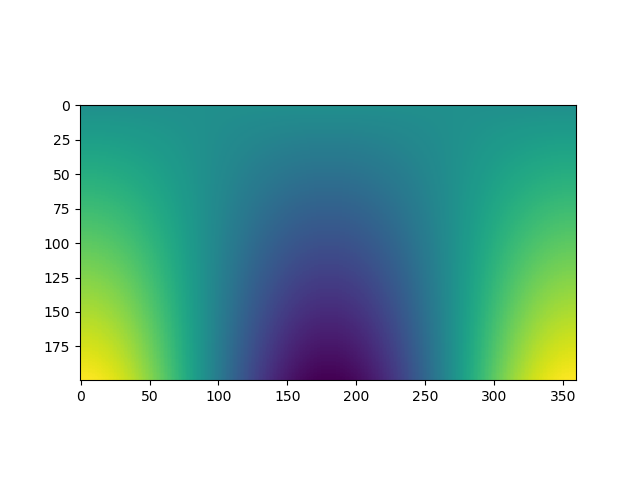

In [406]:
plt.imshow(LUT[:, :, 0])

<IPython.core.display.Javascript object>


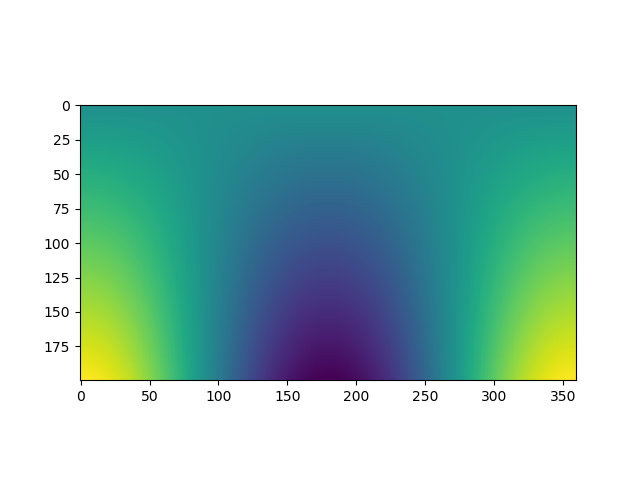

In [412]:
plt.imshow(LUT_new[:200, :, 0])

<IPython.core.display.Javascript object>


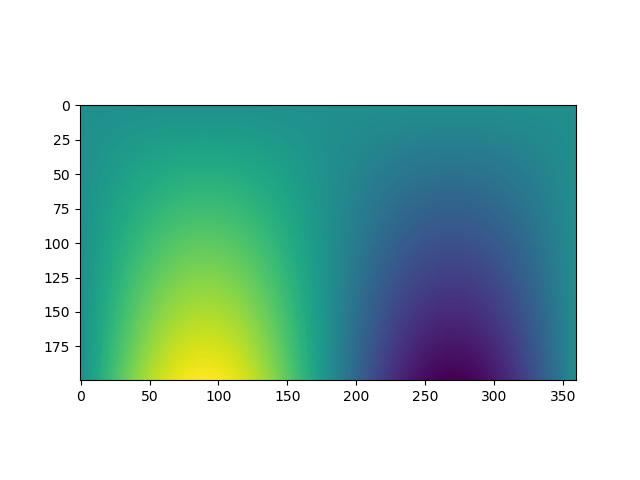

In [415]:
plt.imshow(LUT[:, :, 1])

<IPython.core.display.Javascript object>


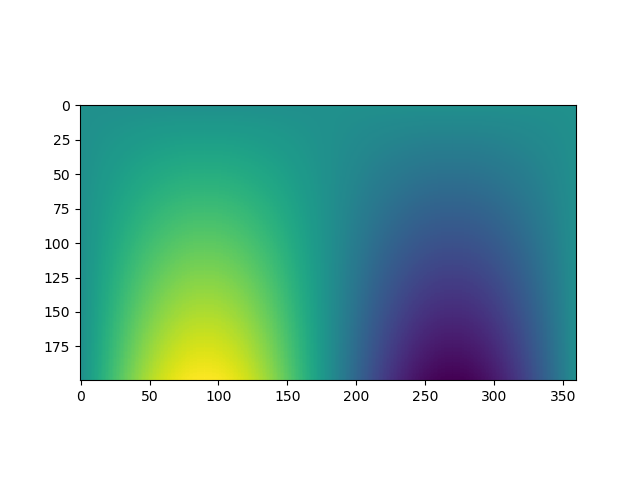

In [416]:
plt.imshow(LUT_new[:200, :, 1])

Watch your indices! Yes - these are equal.

Now let's turn into an alternative function and work out how to do the mapping as a single matrix indexing operation.

In [420]:
def calculateLUT(radius):
    """Precalculate a lookup table with the image maths."""
    # Create 1D ranges for angles and radius
    angle = np.arange(0, 360)
    radius = np.arange(0, radius)
    # Create a mesh grid based on angle and radius
    av, rv = np.meshgrid(angle, radius)
    # Compute rows and column co-ordinates
    cols = (rv*np.sin(av*np.pi/180)).astype(np.int16)
    rows = (rv*np.cos(av*np.pi/180)).astype(np.int16)
    # Create a new LUT of shape (radius, angle, 2)
    LUT = np.stack([rows, cols], axis=-1)
    return LUT

In [421]:
from src.sources.polar_mapping import calculateLUT as cLUT_old

In [422]:
%%timeit
LUT = calculateLUT(400)

4.65 ms ± 372 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [423]:
%%timeit
LUT = cLUT_old(400)

353 ms ± 6.15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Big speed up with numpy vectorised calculations.

In [424]:
rows_out = 200 - LUT[..., 0]

In [425]:
rows_out.shape

(200, 360)

In [426]:
out = np.asarray([0, 0]) - LUT[..., :]

In [427]:
out.shape

(200, 360, 2)

In [430]:
print(out[0:10, 100, 0], LUT_new[0:10, 100, 0])

[0 1 1 1 1 1 2 2 2 2] [ 0  0  0  0  0  0 -1 -1 -1 -1]


In [432]:
LUT_new.shape

(400, 360, 2)

In [436]:
LUT_centered = np.zeros(shape=LUT_new.shape, dtype=np.int16)
LUT_centered[..., 0] = 200 - LUT_new[..., 0] 
LUT_centered[..., 1] = 100 + LUT_new[..., 1] 

In [437]:
print(LUT_centered[100,100], LUT_new[100,100])

[217 198] [-17  98]


We can use meshgrid again to do the LUT lookup?

We could re-use the previous generated meshgrid?

The LUT will save us a bit of time on the sin and cos computations and the division. But we could also do the conversion with a single operation.

The image centering could also be performed beforehand if we always look at the image centre and move the camera...

<IPython.core.display.Javascript object>


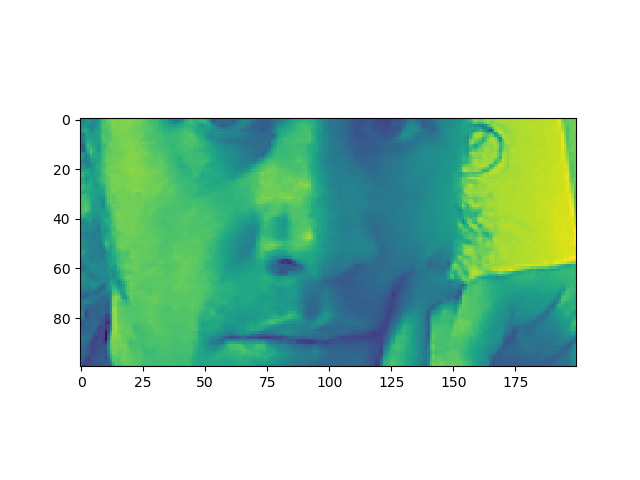

In [439]:
plt.imshow(region)

In [440]:
LUT_new.max(), LUT_new.min()

(399, -399)

In [441]:
LUT_centered.max(), LUT_centered.min()

(599, -299)

In [442]:
LUT_centered[0:5, 0:5]

array([[[200, 100],
        [200, 100],
        [200, 100],
        [200, 100],
        [200, 100]],

       [[199, 100],
        [200, 100],
        [200, 100],
        [200, 100],
        [200, 100]],

       [[198, 100],
        [199, 100],
        [199, 100],
        [199, 100],
        [199, 100]],

       [[197, 100],
        [198, 100],
        [198, 100],
        [198, 100],
        [198, 100]],

       [[196, 100],
        [197, 100],
        [197, 100],
        [197, 100],
        [197, 100]]], dtype=int16)

In [446]:
region[LUT_new[0:5, 0:5].flatten()].shape

(50, 200)

<IPython.core.display.Javascript object>


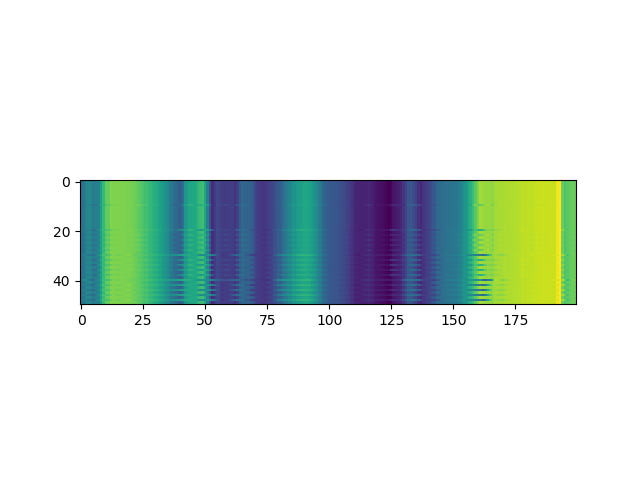

In [447]:
plt.imshow(region[LUT_new[0:5, 0:5].flatten()])

In [449]:
np.take(region, LUT_new[0:5, 0:5]).shape

(5, 5, 2)

In [451]:
region[LUT_centered[...,0]<, LUT_centered[...,1]]

IndexError: index 200 is out of bounds for axis 0 with size 100

In [452]:
LUT_centered[...,0]<100

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [456]:
(LUT_centered[...,0]<100).shape

(400, 360)

In [457]:
LUT_centered[...,0].shape

(400, 360)

In [453]:
# Get LUT values that are less than max radius
clipped_row = LUT_new[..., 0][LUT_new[..., 0] < region.shape[0]]
clipped_col = LUT_new[..., 1][LUT_new[..., 1] < region.shape[1]]

In [455]:
clipped_row.shape

(107306,)

In [458]:
region.shape

(100, 200)

In [459]:
region[100,0]

IndexError: index 100 is out of bounds for axis 0 with size 100

We need some constraint on the LUT_centered such that if the values are > than the size we just have 0.

When we use the indexing above, this just selects all the values in the indicated 0-dimension of the LUT that meet the criteria.

We want something similar to setting all those values with False to 0 - these are not to be used.

So we could do a clipping - all values > shape are set as the shape. This will overwrite the border.

In [454]:
# Test using LUT as lookup
region[clipped_row, clipped_col]

IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (107306,) (126250,) 

In [468]:
LUT_clipped = LUT_new.copy()
LUT_clipped[..., 0][LUT_new[..., 0] >= region.shape[0]] = region.shape[0]-1
LUT_clipped[..., 1][LUT_new[..., 1] >= region.shape[1]] = region.shape[1]-1
LUT_clipped[..., 0][LUT_new[..., 0] <= -1*region.shape[0]] = -1*(region.shape[0]-1)
LUT_clipped[..., 1][LUT_new[..., 1] <= -1*region.shape[1]] = -1*(region.shape[1]-1)

In [469]:
LUT_clipped[..., 0].max(), LUT_clipped[..., 0].min()

(99, -99)

In [470]:
LUT_clipped[..., 1].max(), LUT_clipped[..., 1].min()

(199, -199)

To generate the output image we just need to generate a new image of size r, angle - 
```
output = np.zeros(shape=LUT.shape, dtype=np.uint8)
output = img[
```

In [471]:
a = np.asarray([[0, 3],   # a[0,[0,1]]
       [6, 0],   # a[1,[1,2]] 
       [0, 9]])  # a[2,[0,2]]
a.shape

(3, 2)

In [472]:
b = np.array([[0,3,4],
              [5,6,0],
              [0,1,9]])
b.shape

(3, 3)

I want out[i, j] = I[LUT[i, j, 0], LUT[i, j, 1]].

# The later functions in polar_mapping.py provide a vectorised solution.

```
def img2polar(img, center, final_radius, LUT, phase_width=256):
    """Map an image to polar co-ordinates."""
    Xcart, Ycart = LUT
    if img.ndim == 3:
        polar_img = img[Ycart, Xcart, :]
        polar_img = np.reshape(
            polar_img, (final_radius, phase_width, 3)
        )
    else:
        polar_img = img[Ycart, Xcart]
        polar_img = np.reshape(
            polar_img, (final_radius, phase_width)
        )

    return polar_img
```
The lookup table is provides as two arrays - rows and columns - Ycart, Xcart.

So we can just do ```img[LUT_rows, LUT_cols]``` - then just reshape to the radius and the number of angles?

In [480]:
from src.sources.polar_mapping import generateLUT

LUT_method2 = generateLUT((0,0), 50)

In [481]:
LUT_method2[0].shape

(50, 256)

In [482]:
region.shape

(100, 200)

In [483]:
LUT_method2[0].max()

48

In [484]:
mapped = region[LUT_method2[0]+50, LUT_method2[1]+100]

In [485]:
mapped.shape

(50, 256)

<IPython.core.display.Javascript object>


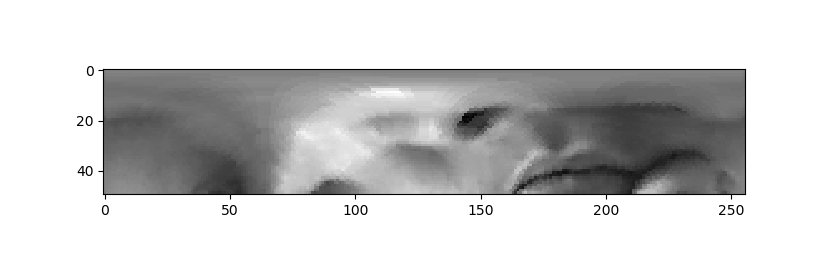

In [488]:
plt.imshow(mapped, cmap="gray")

<IPython.core.display.Javascript object>


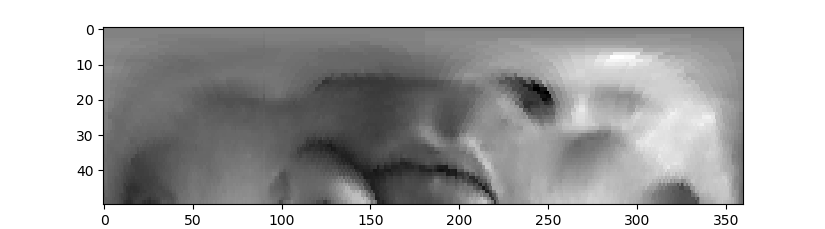

In [489]:
# This is our converted one
plt.imshow(converted.T, cmap='gray', aspect="auto")

The LUT one is the same, just the rotation starts from a different point - probably due to the np.pi/2 factor.

In [495]:
mapped2 = region[LUT_clipped[..., 0], LUT_clipped[..., 1]]

<IPython.core.display.Javascript object>


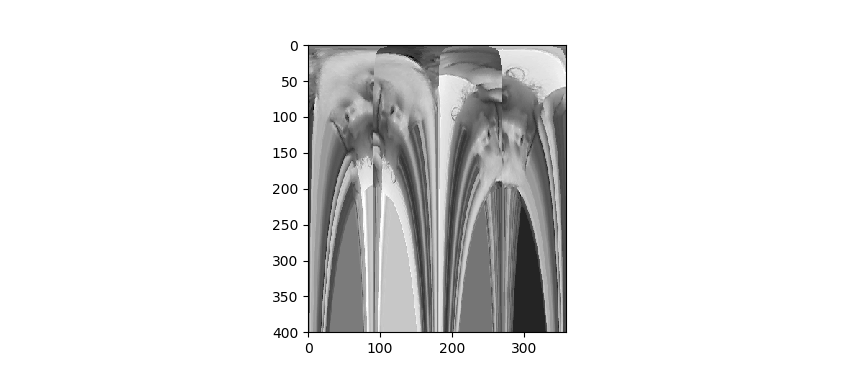

In [496]:
plt.imshow(mapped2, cmap="gray")

Hmmm - no that doesn't work!

Here's an example with an alternative GUI.

https://stackoverflow.com/questions/15460706/opencv-cv2-in-python-videocapture-not-releasing-camera-after-deletion

In [499]:
video2.cap.release()

In [ ]:
def polar2cart(r, theta, center):
    """Convert polar co-ordinates to Cartesian."""
    x = r * np.cos(theta) + center[0]
    y = r * np.sin(theta) + center[1]
    return x, y


def generateLUT(center, final_radius, phase_width=256):
    """Generate a look-up table for polar mapping."""
    initial_radius = 0
    theta, R = np.meshgrid(
        np.linspace(0, 2*np.pi, phase_width),
        np.arange(initial_radius, final_radius)
    )

    Xcart, Ycart = polar2cart(R, theta, center)

    Xcart = Xcart.astype(int)
    Ycart = Ycart.astype(int)
    return (Xcart, Ycart)


def img2polar(img, center, final_radius, LUT, phase_width=256):
    """Map an image to polar co-ordinates."""
    Xcart, Ycart = LUT
    if img.ndim == 3:
        polar_img = img[Ycart, Xcart, :]
        polar_img = np.reshape(
            polar_img, (final_radius, phase_width, 3)
        )
    else:
        polar_img = img[Ycart, Xcart]
        polar_img = np.reshape(
            polar_img, (final_radius, phase_width)
        )

    return polar_img

In [121]:
def polar2cart(r, theta):
    """Convert polar co-ordinates to Cartesian."""
    row = r * np.cos(theta)
    col = r * np.sin(theta)
    return row, col

def generateLUT(radius, phase_width=256):
    """Generate a look-up table for polar mapping.
    
    Args:
        radius - integer specifying radius in pixels.
        phase_width - integer specifying angle resolution."""
    theta, R = np.meshgrid(
        np.linspace(0, 2*np.pi, phase_width),
        np.arange(0, radius)
    )

    rows, cols = polar2cart(R, theta)

    rows = rows.astype(int)
    cols = cols.astype(int)
    # Create a new LUT of shape (radius, angle, 2)
    LUT = np.stack([rows, cols], axis=-1)
    return LUT

def convert_image(image, LUT):
    """Precalculate a lookup table with the image maths."""
    # Determine image size
    rows, cols = image.shape[:2]
    # Use centre of image as origin
    centre_row = rows // 2
    centre_col = cols // 2
    # Determine LUT size
    max_radius, angles, _ = LUT.shape
    # Determine radius
    radius = min(max_radius, centre_row, centre_col)
    # Adjust LUT to centre and clip so indices are within bounds
    rows = np.clip(centre_row - LUT[..., 0], 0, centre_row+radius-1)
    cols = np.clip(centre_col + LUT[..., 1], 0, centre_col+radius-1)
    # If multiple components
    if image.ndim == 3:
        output = image[rows, cols, :]
    else:
        output = image[rows, cols]
    # Crop based on min radius
    return output[:radius, ...]

In [102]:
LUT = generateLUT(400)
LUT.shape

(400, 256, 2)

In [81]:
image = frame[:, :, 0]

In [82]:
rows, cols = image.shape
# Use centre of image as origin
centre_row = rows // 2
centre_col = cols // 2

In [83]:
# Adjust LUT for centre
LUT_centered = np.zeros(shape=LUT.shape, dtype=np.int16)
LUT_centered[..., 0] = centre_row - LUT[..., 0] 
LUT_centered[..., 1] = centre_col + LUT[..., 1]

In [84]:
image.shape

(480, 640)

In [85]:
LUT_clipped = np.clip(LUT_centered, 0, image.shape[0]-1)

In [86]:
mapped = image[LUT_clipped[..., 0], LUT_clipped[..., 1]]
mapped.shape

(400, 256)

<IPython.core.display.Javascript object>


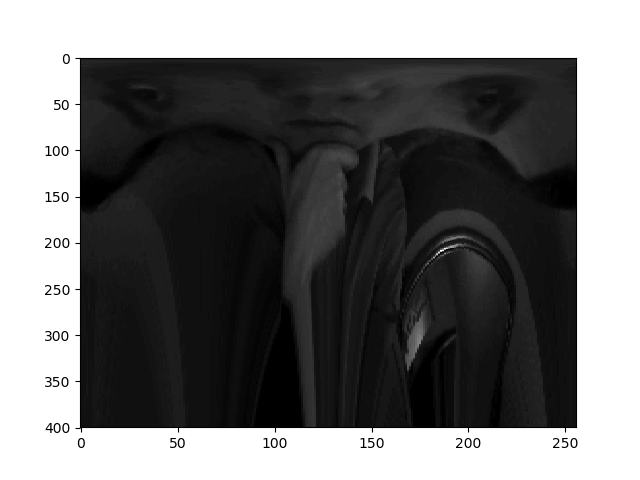

In [88]:
plt.imshow(mapped, cmap="gray", aspect="auto")

This is why we need the centre in the lookup table...?

In [75]:
output = convert_image(image, LUT)

In [76]:
output.shape

(400, 256)

<IPython.core.display.Javascript object>


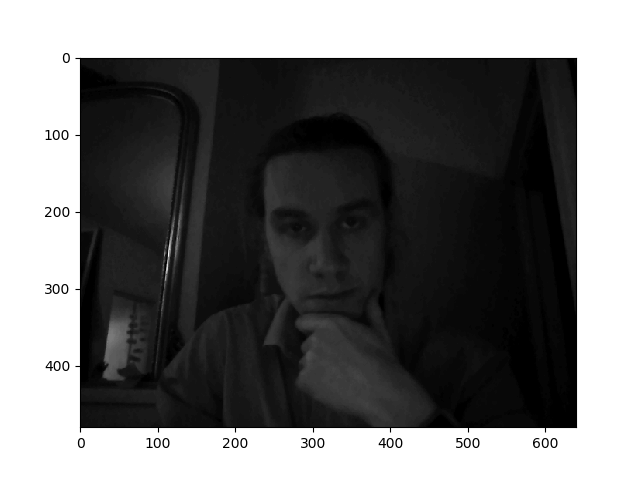

In [77]:
%matplotlib notebook
plt.imshow(image, cmap="gray", aspect="auto")

<IPython.core.display.Javascript object>


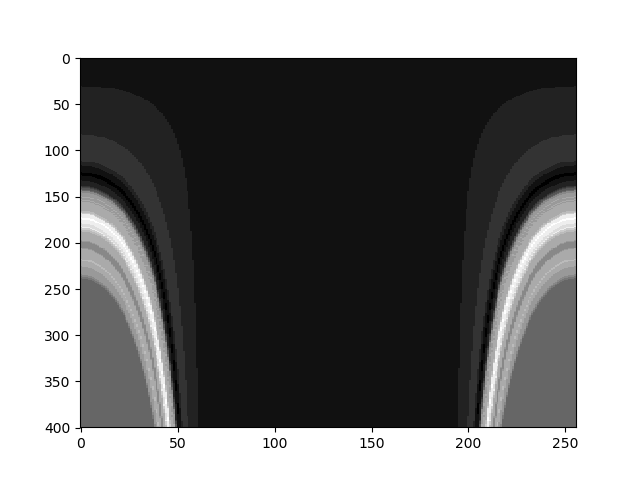

In [79]:
plt.imshow(output, cmap="gray", aspect="auto")

# Region Centering

The examples above seem to suggest a quick and dirty way to centre and align the region. We sum up each quadrant. We then want to adjust to make them equal (or minimise?).

Each quadrant provides a value that can be made into a translation matrix for the centre position.

In [107]:
LUT = generateLUT(400)
print(LUT.shape)
# Determine image size
rows, cols = image.shape
# Use centre of image as origin
centre_row = rows // 2
centre_col = cols // 2
print(centre_row, centre_col)
# Determine LUT size
max_radius, angles, _ = LUT.shape
# Determine radius
radius = min(max_radius, centre_row, centre_col)
print(radius)
# Adjust LUT to centre
rows = np.clip(centre_row - LUT[..., 0], 0, centre_row+radius-1)
cols = np.clip(centre_col + LUT[..., 1], 0, centre_col+radius-1) 
output = image[rows, cols]
output = output[:radius, :radius]
plt.imshow(output, cmap="gray", aspect="auto")

(400, 256, 2)
240 320
240


<IPython.core.display.Javascript object>


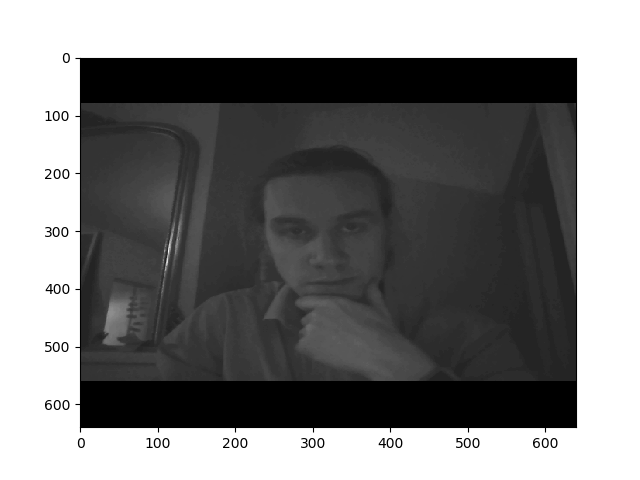

In [99]:
plt.imshow(padded, cmap="gray", aspect="auto")

<IPython.core.display.Javascript object>


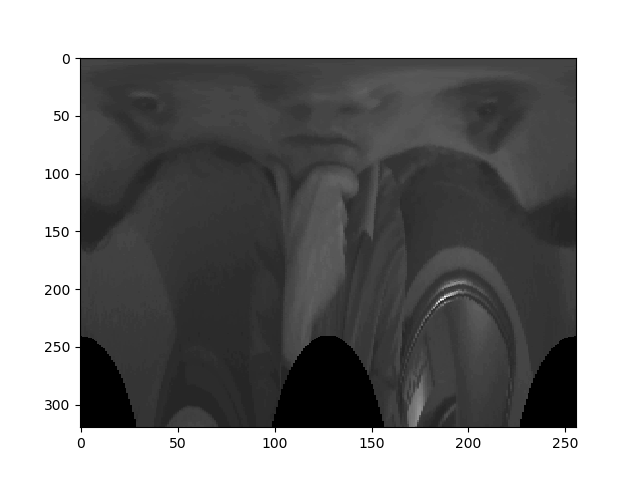

In [109]:
padded = squarify(image, 0)
output = convert_image(padded, LUT)
plt.imshow(output, cmap="gray", aspect="auto")

<IPython.core.display.Javascript object>


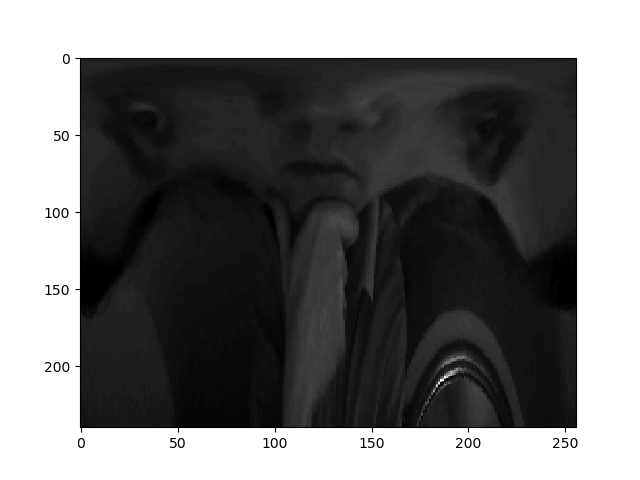

In [122]:
converted = convert_image(image, LUT)
plt.imshow(converted, cmap="gray", aspect="auto")

In [104]:
video.stop()

In [111]:
frame.shape

(480, 640, 2)

In [123]:
converted_all = convert_image(frame, LUT)

In [126]:
converted_all.shape

(240, 256, 2)

In [125]:
frame.ndim

3